In [ ]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
# visualization function

def show(tensor, ch=1, size=(28,28), num=16):
  #tensors: 128 * 784 (batchsize * num of pixels(28*28))
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid=make_grid(data[:num],nrow=4).permute(1,2,0)  #permute is to reshape from torch shape to matplot lib shape
  plt.imshow(grid)
  plt.show()


In [ ]:
#setup of the main and hyper parameter
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)

#number of steps in each epoch = 60000 /128 = 468.75 (number of images/batchsize)

100%|██████████| 9912422/9912422 [00:00<00:00, 99829065.90it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115038645.61it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26418412.95it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18955750.02it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# relu or any activation function introduces non linearity in the model
# Generator class params --- > size of input noise or latent vector = 64, output vector size = 784(28*28 mnist data size), base size of the first hidden layer of network
# Discriminator class params --- > dimension of the image, default size of hidden layer

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace = True)
  )


## Generator
class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()    # initializing the parent class
    self.gen = nn.Sequential(
        genBlock(z_dim,h_dim),   # 64, 128
        genBlock(h_dim, h_dim*2),  # 128, 256
        genBlock(h_dim *2, h_dim *4), # 256, 512
        genBlock(h_dim*4, h_dim*8),  # 512, 1024
        nn.Linear(h_dim *8, i_dim),   # 1024, 784(28,28)
        nn.Sigmoid()  # to make the output between 0 and 1
    )

  def forward(self,noise):
    return self.gen(noise)


def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)    # store the output in gpu



## Discriminator
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim,h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024,512
        discBlock(h_dim*2, h_dim),  # 512, 256
        nn.Linear(h_dim,1)  # 256,1
     )

  def forward(self,image):
      return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 6, 2, 8, 9, 7, 2, 4, 1, 8])


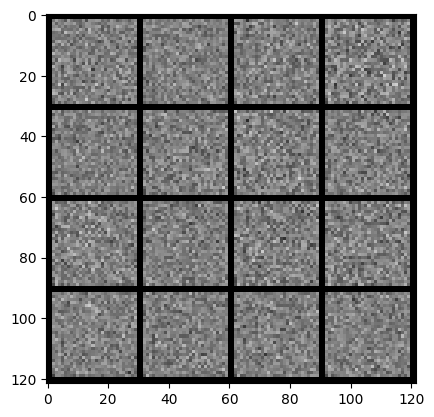

In [ ]:
x,y=next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func,gen,disc,number,z_dim):
  noise = gen_noise(number,z_dim)  # number is the batch size
  fake=gen(noise)
  pred = disc(fake)
  targets =torch.ones_like(pred)   # this will create a vector with dim similar to pred, generator must be able to fool the disc, hence the disc actual o/p must be 1
  gen_loss=loss_func(pred,targets)
  return gen_loss

# discriminator loss
def calc_disc_loss(loss_func,gen,disc,number,real,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  disc_fake=disc(fake.detach()) # detach because we dont want to change the parameters of generator(while back propogates)
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_targets)

  disc_real=disc(real)
  disc_real_targets=torch.ones_like(disc_real)
  disc_real_loss=loss_func(disc_real,disc_real_targets)
  disc_loss=(disc_fake_loss+disc_real_loss)/2
  return disc_loss

In [ ]:
epochs = 70

  0%|          | 0/469 [00:00<?, ?it/s]

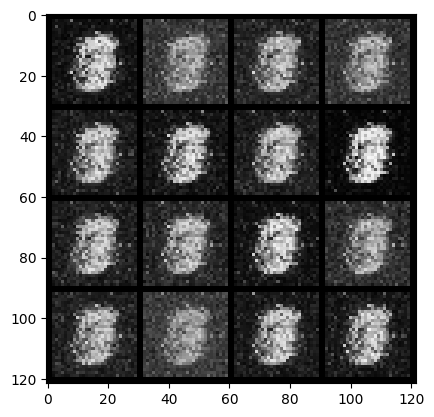

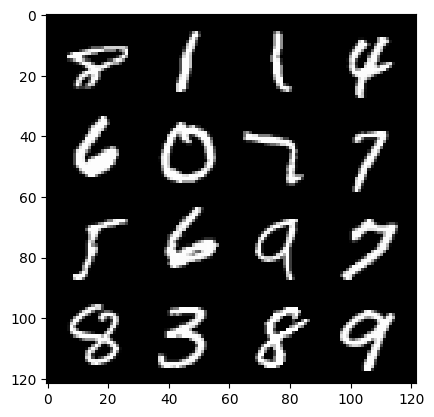

0: step 300 / Gen loss: 1.9716693242390944 / Disc loss: 0.33276475432018393


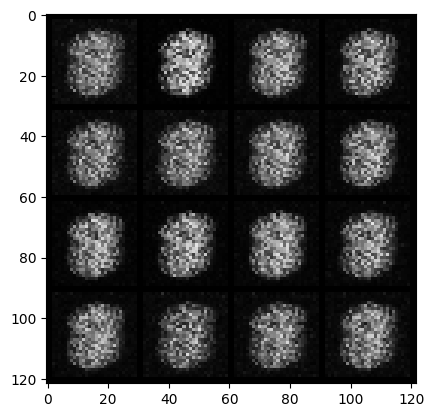

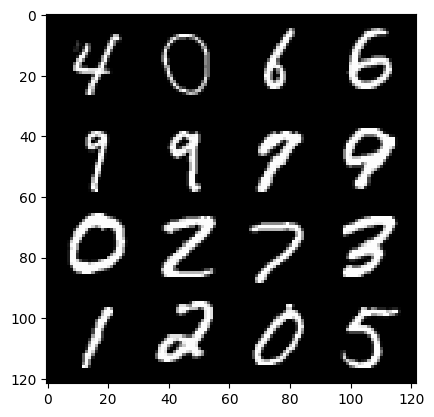

0: step 600 / Gen loss: 3.489384897549944 / Disc loss: 0.11499156142274534


  0%|          | 0/469 [00:00<?, ?it/s]

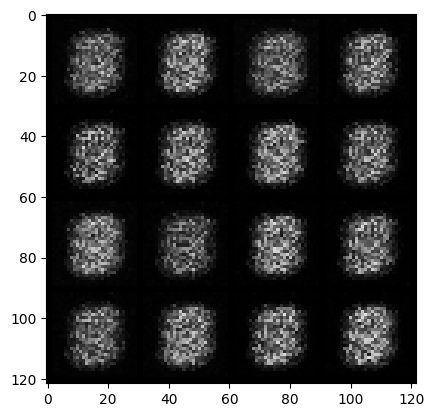

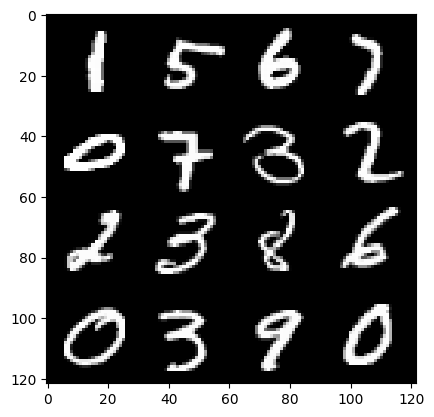

1: step 900 / Gen loss: 3.4183052221933994 / Disc loss: 0.05748309681812914


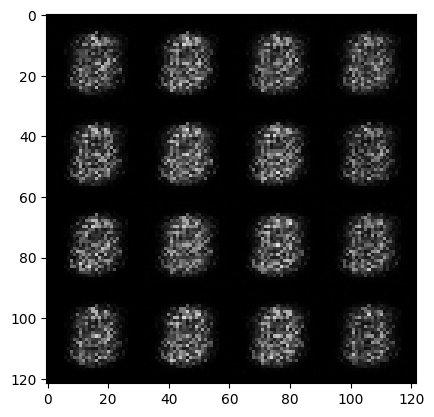

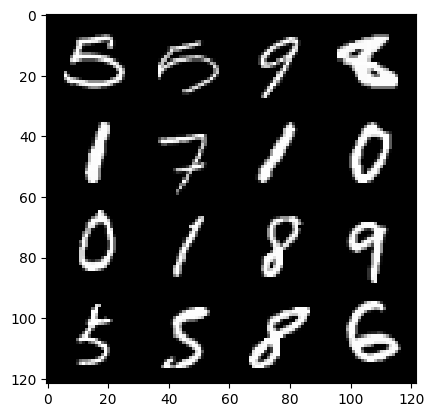

1: step 1200 / Gen loss: 3.3697783009211197 / Disc loss: 0.04248655145366986


  0%|          | 0/469 [00:00<?, ?it/s]

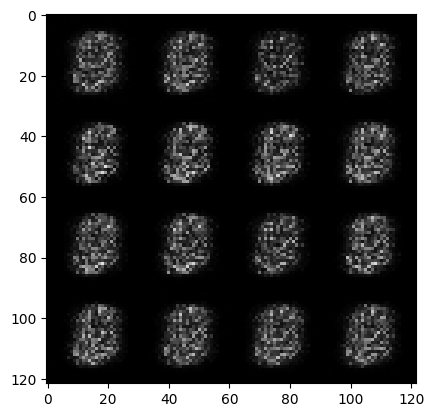

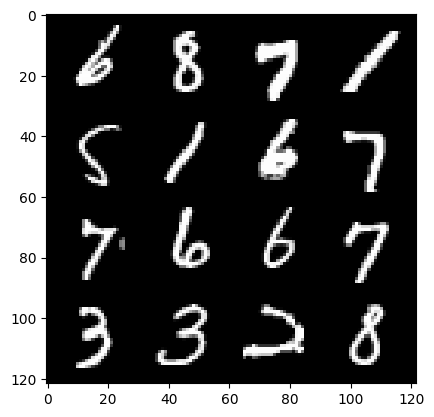

2: step 1500 / Gen loss: 3.355295896530152 / Disc loss: 0.04267358851929506


  0%|          | 0/469 [00:00<?, ?it/s]

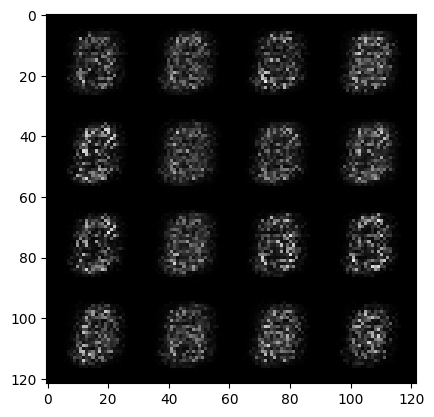

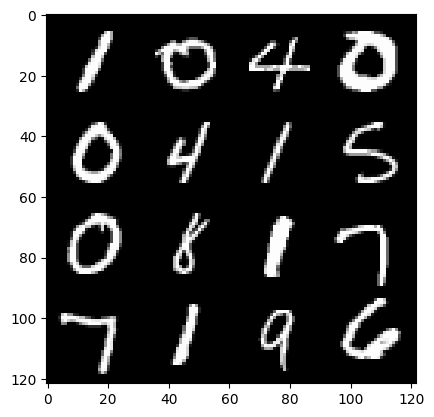

3: step 1800 / Gen loss: 3.5218372225761434 / Disc loss: 0.039557270358006165


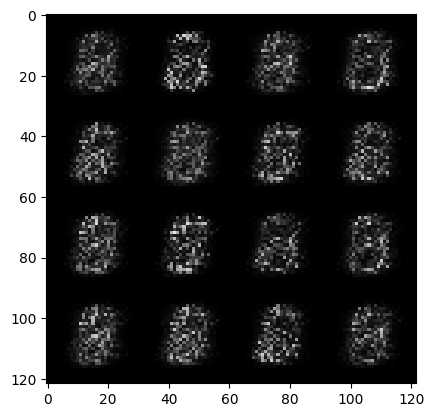

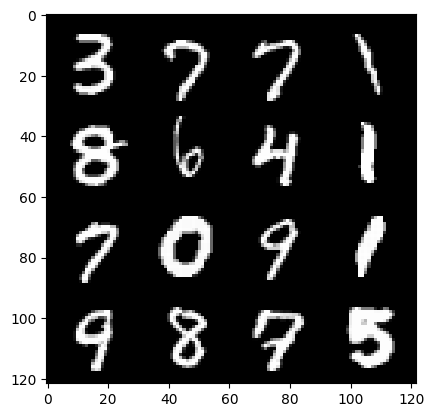

3: step 2100 / Gen loss: 3.679447983900706 / Disc loss: 0.03642590379342436


  0%|          | 0/469 [00:00<?, ?it/s]

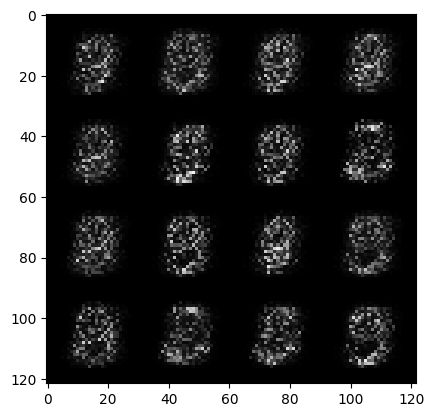

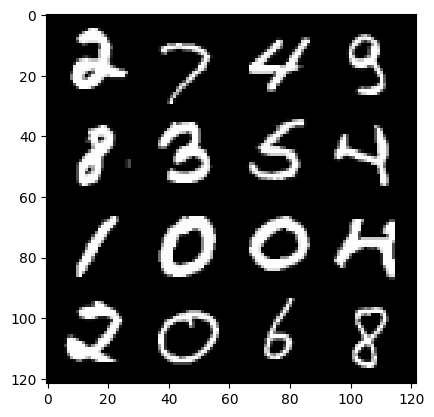

4: step 2400 / Gen loss: 4.163576975663502 / Disc loss: 0.028476537726819517


  0%|          | 0/469 [00:00<?, ?it/s]

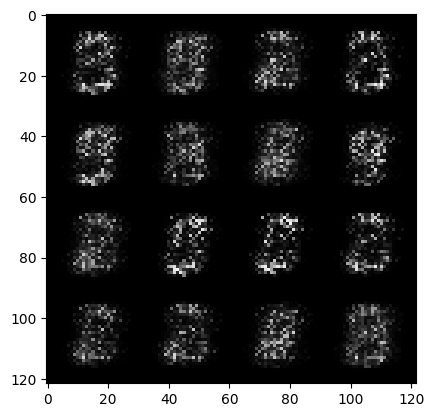

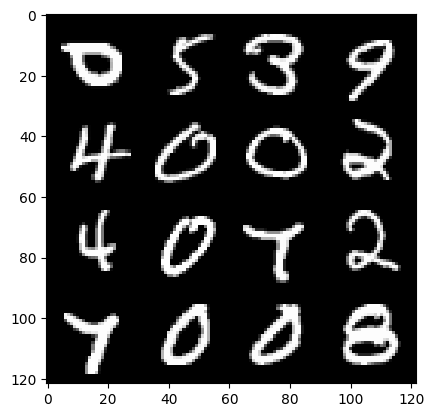

5: step 2700 / Gen loss: 4.5878791077931655 / Disc loss: 0.0244521137389044


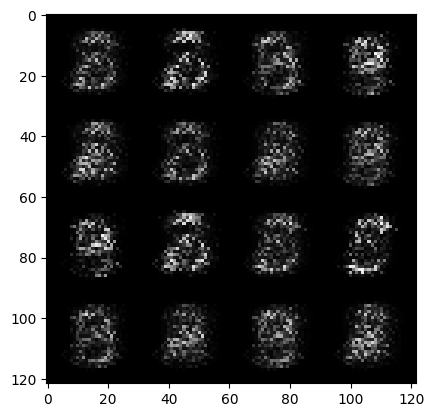

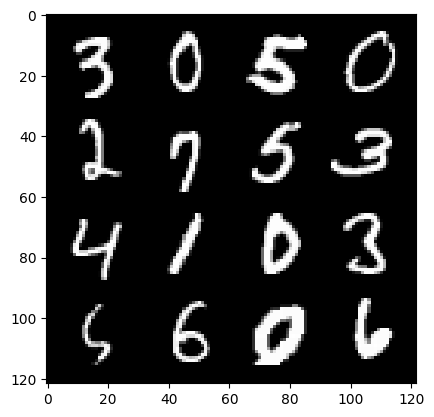

5: step 3000 / Gen loss: 5.002132733662924 / Disc loss: 0.019819902970145152


  0%|          | 0/469 [00:00<?, ?it/s]

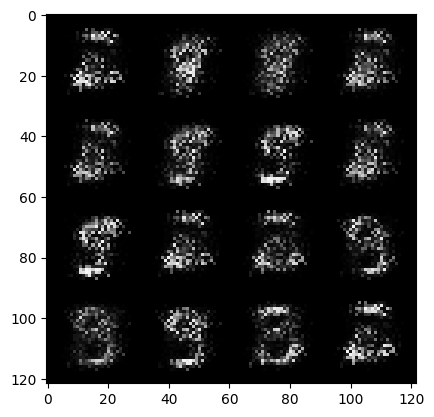

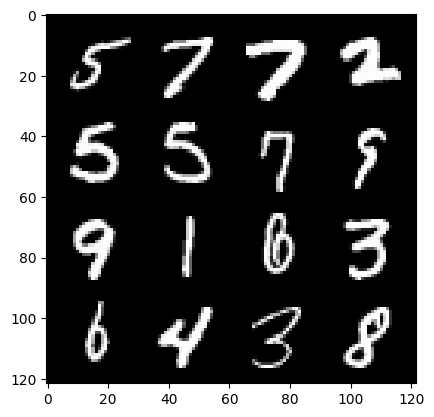

6: step 3300 / Gen loss: 5.131981272697451 / Disc loss: 0.01957644303639729


  0%|          | 0/469 [00:00<?, ?it/s]

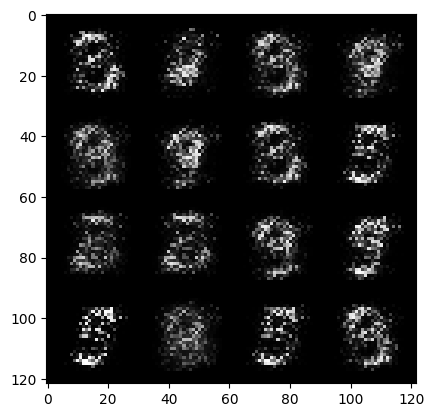

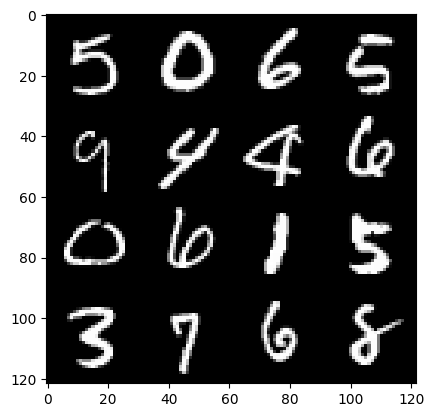

7: step 3600 / Gen loss: 5.226807624499002 / Disc loss: 0.02010916893680889


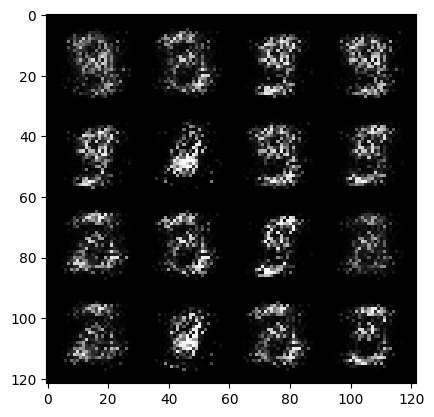

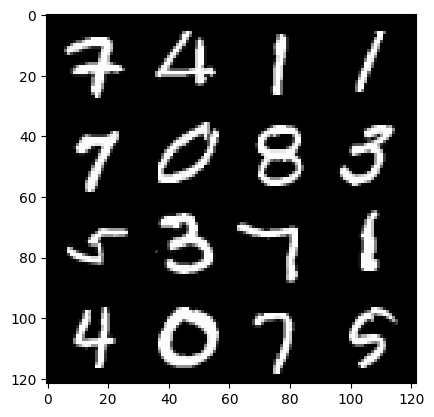

7: step 3900 / Gen loss: 5.658072524070738 / Disc loss: 0.015256882527222232


  0%|          | 0/469 [00:00<?, ?it/s]

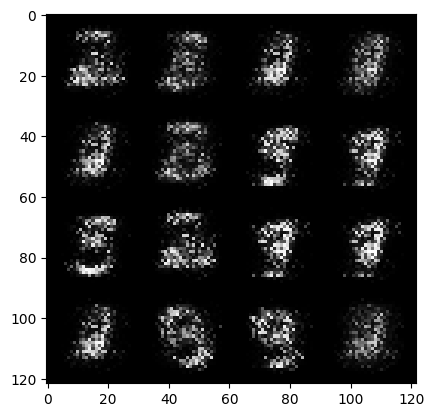

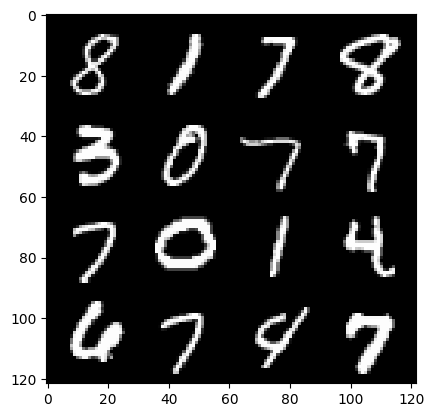

8: step 4200 / Gen loss: 5.902102950414016 / Disc loss: 0.015401143909742444


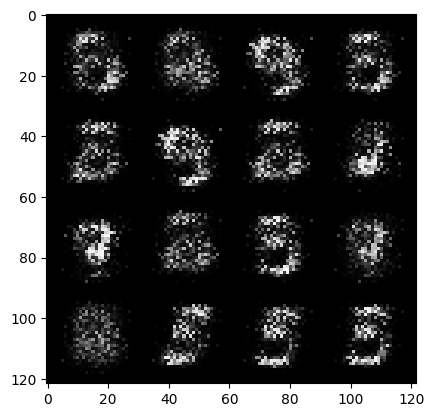

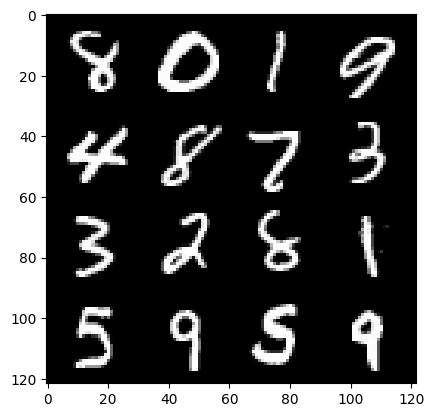

8: step 4500 / Gen loss: 5.9968708054224695 / Disc loss: 0.01391497066399703


  0%|          | 0/469 [00:00<?, ?it/s]

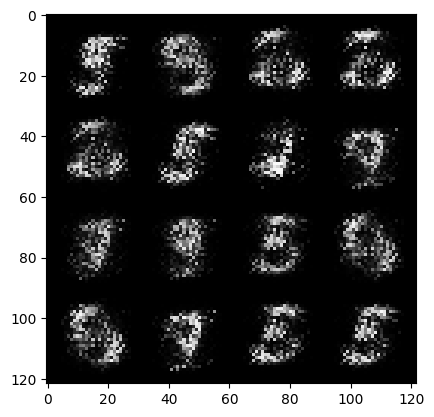

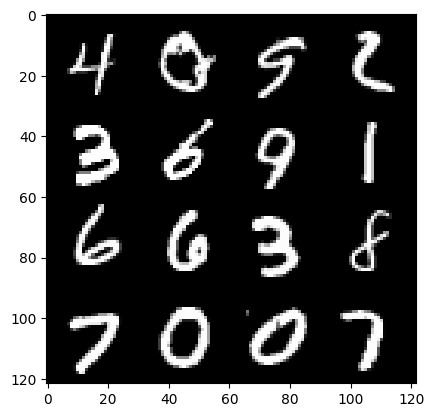

9: step 4800 / Gen loss: 6.112503805160522 / Disc loss: 0.01303923458171387


  0%|          | 0/469 [00:00<?, ?it/s]

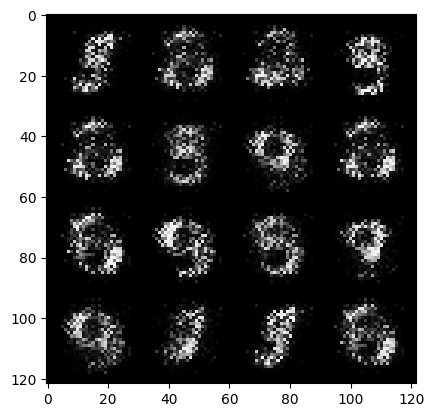

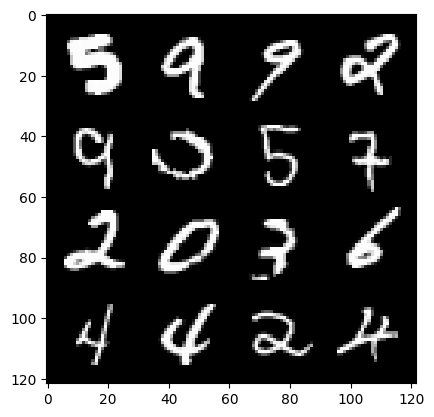

10: step 5100 / Gen loss: 6.04599240144094 / Disc loss: 0.012768045730578409


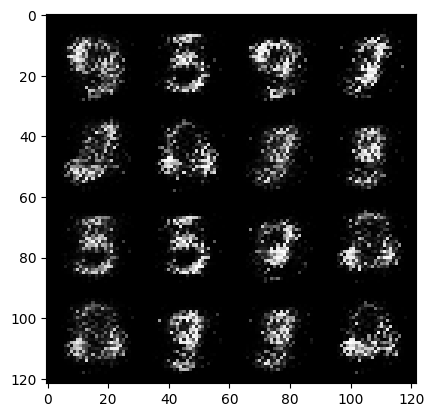

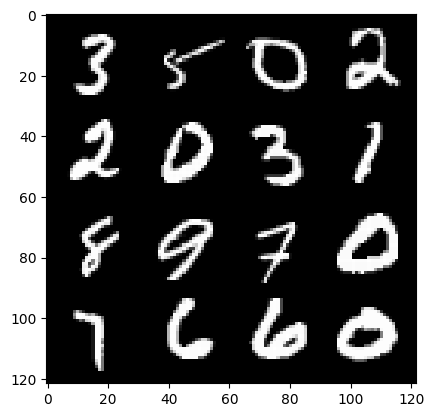

10: step 5400 / Gen loss: 6.80360031763713 / Disc loss: 0.011730209418262045


  0%|          | 0/469 [00:00<?, ?it/s]

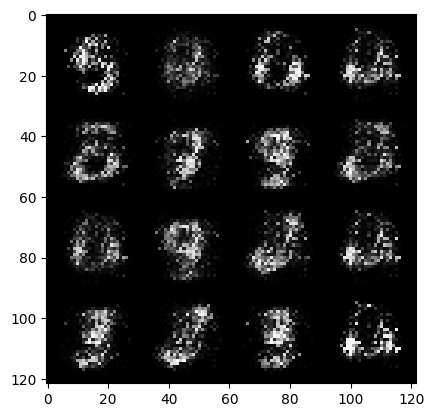

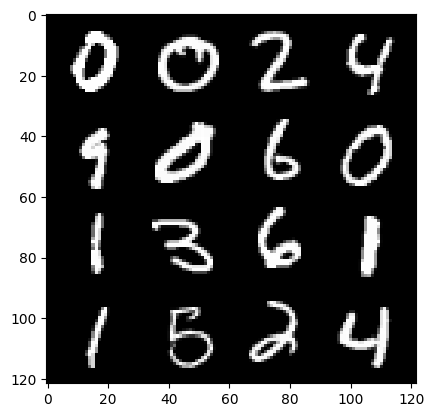

11: step 5700 / Gen loss: 7.02766477108002 / Disc loss: 0.011566292070783675


  0%|          | 0/469 [00:00<?, ?it/s]

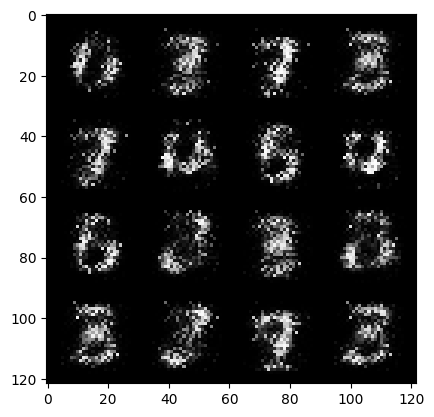

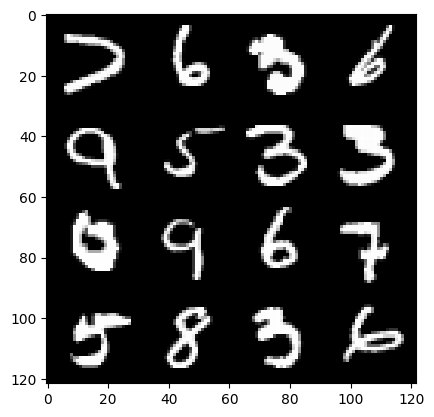

12: step 6000 / Gen loss: 6.630542720158895 / Disc loss: 0.011582986828094966


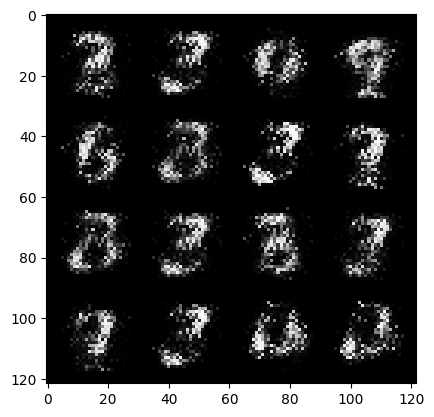

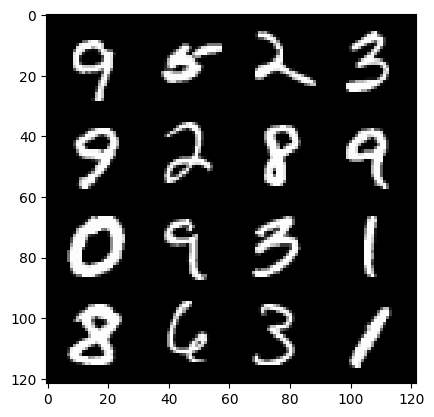

12: step 6300 / Gen loss: 6.645836472511296 / Disc loss: 0.012914943738530079


  0%|          | 0/469 [00:00<?, ?it/s]

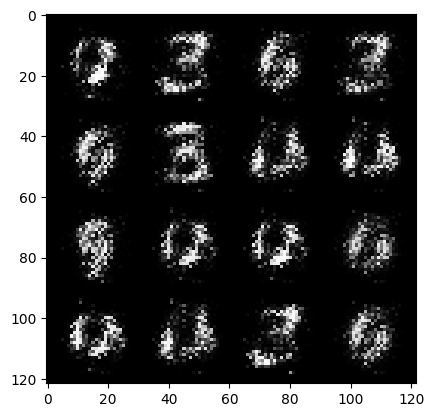

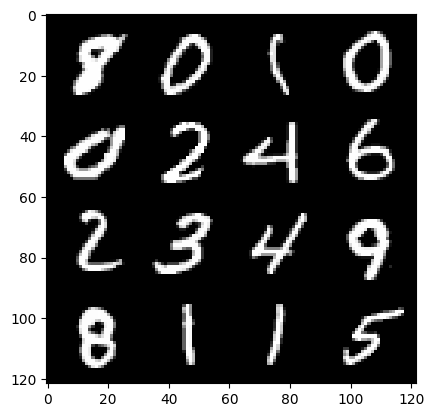

13: step 6600 / Gen loss: 6.241426316897073 / Disc loss: 0.012186860075065252


  0%|          | 0/469 [00:00<?, ?it/s]

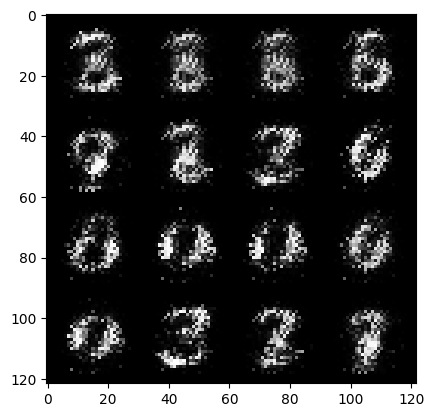

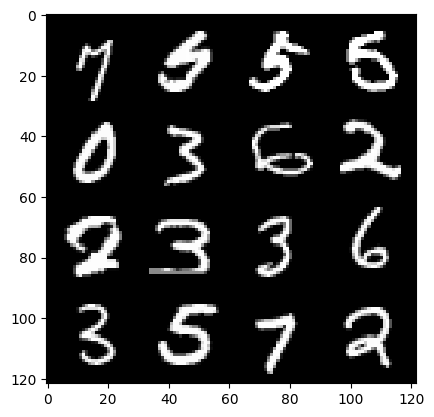

14: step 6900 / Gen loss: 6.462531282107038 / Disc loss: 0.011040201206536343


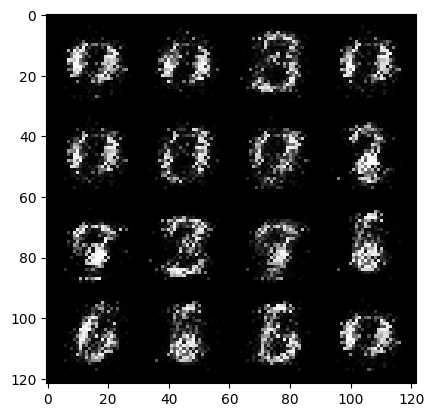

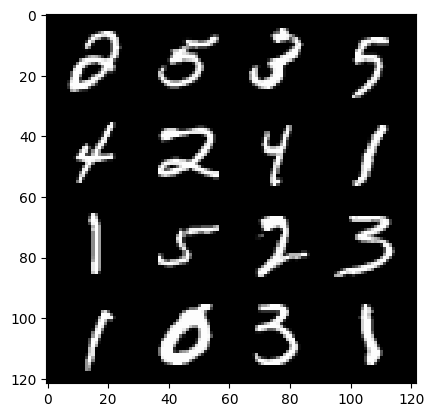

14: step 7200 / Gen loss: 6.856522224744158 / Disc loss: 0.009333012272448593


  0%|          | 0/469 [00:00<?, ?it/s]

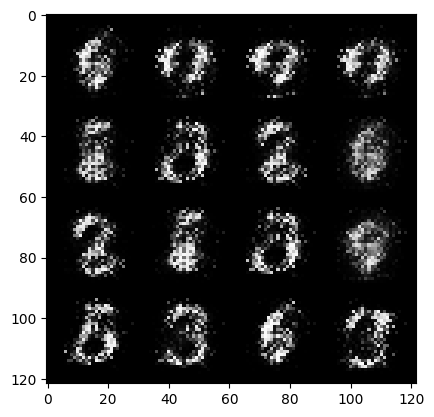

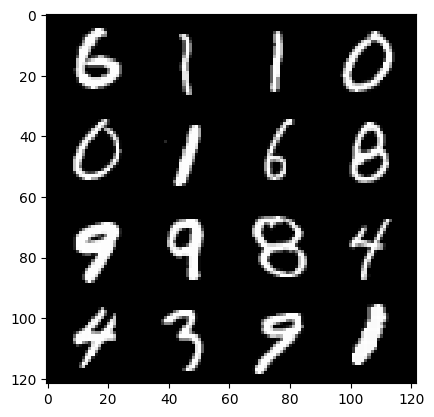

15: step 7500 / Gen loss: 6.860707284609475 / Disc loss: 0.009583748462609941


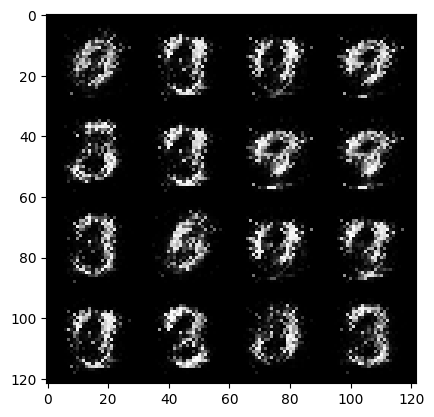

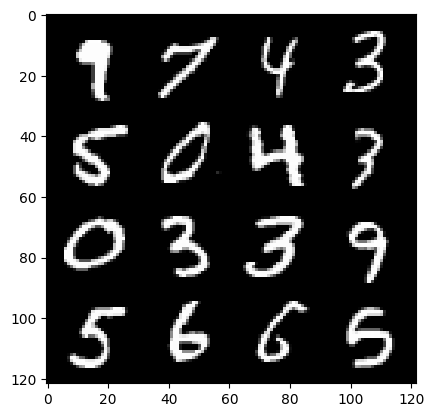

15: step 7800 / Gen loss: 6.823515693346656 / Disc loss: 0.00850463286663096


  0%|          | 0/469 [00:00<?, ?it/s]

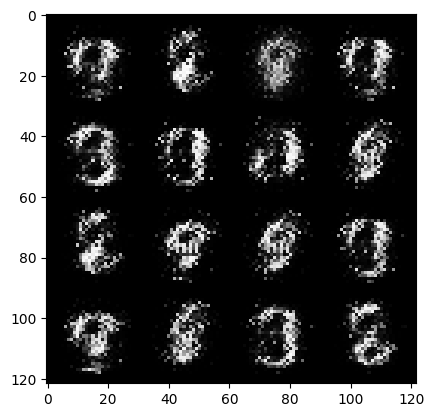

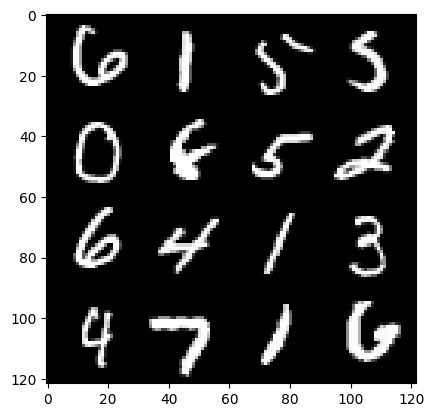

16: step 8100 / Gen loss: 7.003861726125084 / Disc loss: 0.007476465366004656


  0%|          | 0/469 [00:00<?, ?it/s]

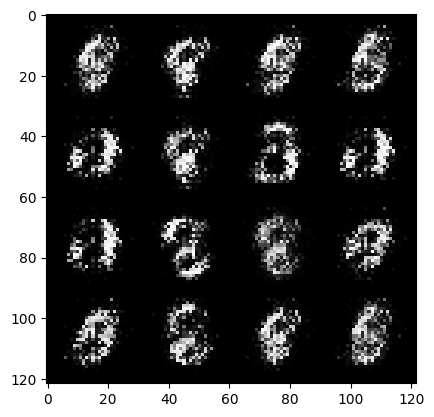

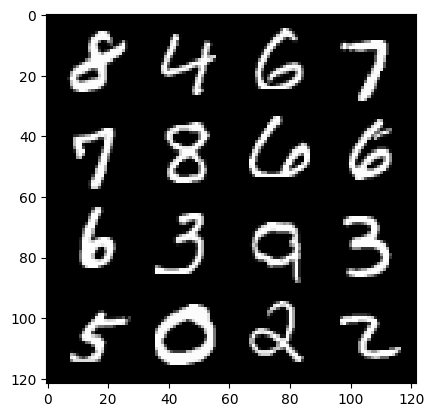

17: step 8400 / Gen loss: 7.138735429445902 / Disc loss: 0.0075165874468317954


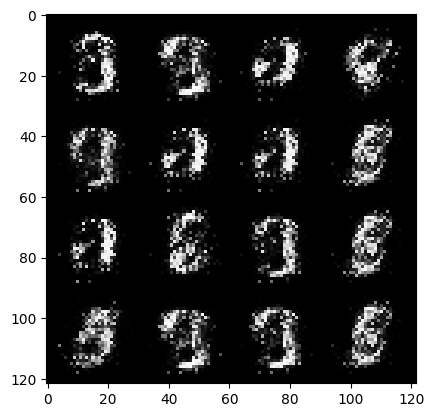

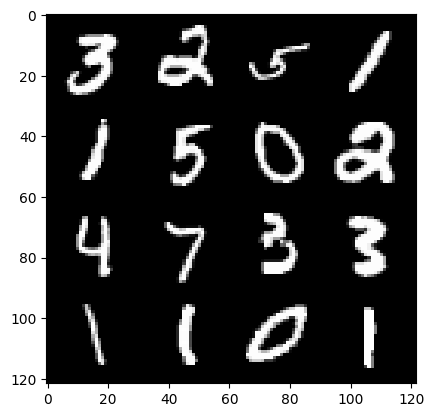

17: step 8700 / Gen loss: 6.901630174318947 / Disc loss: 0.008073608581131944


  0%|          | 0/469 [00:00<?, ?it/s]

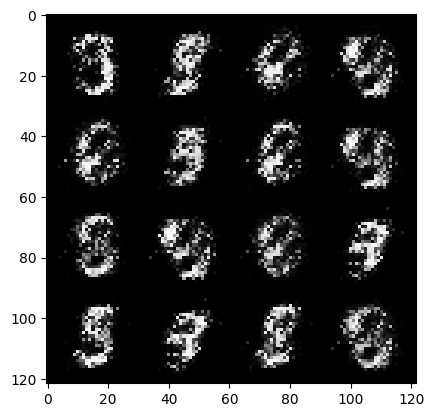

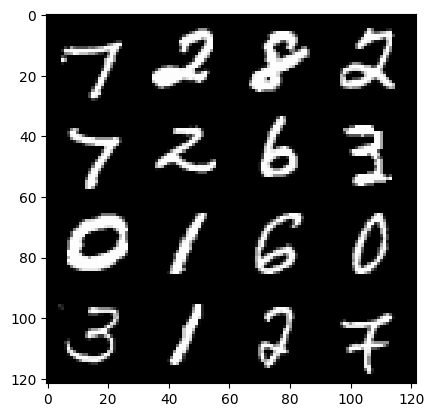

18: step 9000 / Gen loss: 6.858954396247864 / Disc loss: 0.007945062962050243


  0%|          | 0/469 [00:00<?, ?it/s]

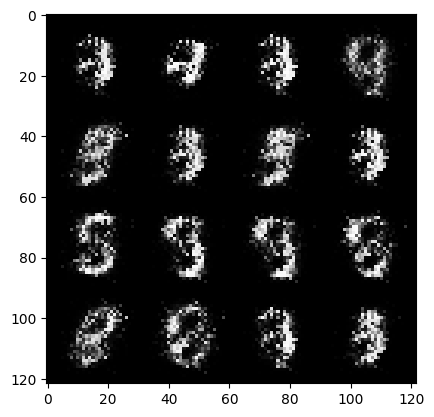

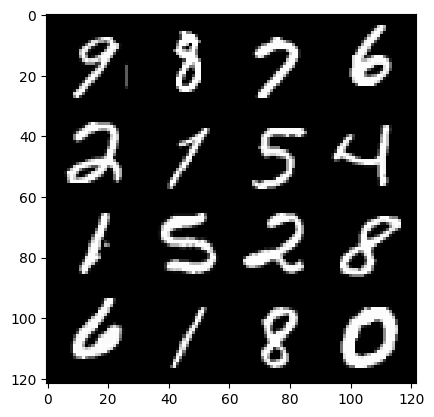

19: step 9300 / Gen loss: 6.979872144063309 / Disc loss: 0.00909356490825303


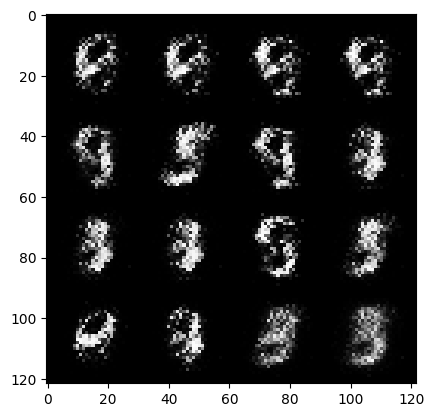

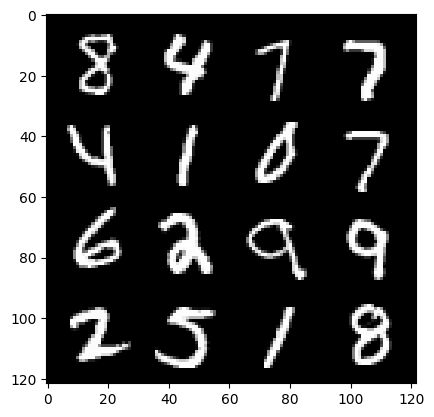

19: step 9600 / Gen loss: 6.857390688260396 / Disc loss: 0.011775700391735885


  0%|          | 0/469 [00:00<?, ?it/s]

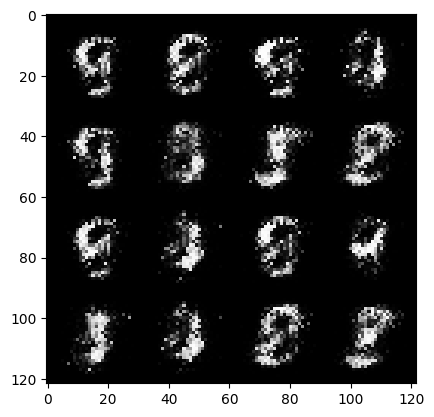

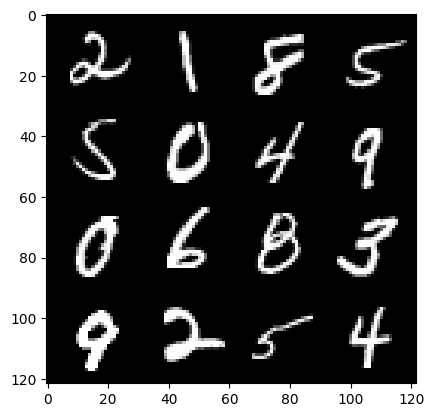

20: step 9900 / Gen loss: 6.593549710909528 / Disc loss: 0.014364268764232597


  0%|          | 0/469 [00:00<?, ?it/s]

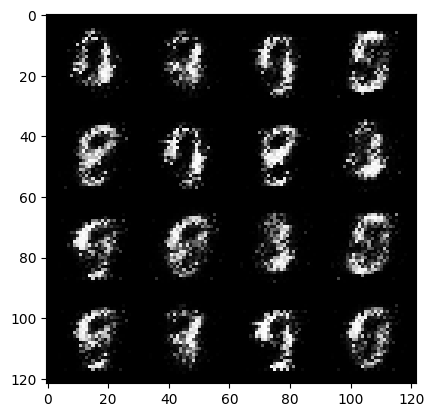

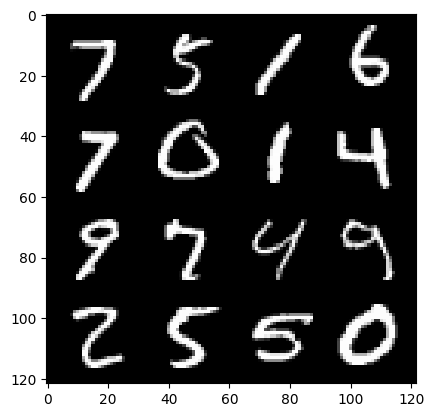

21: step 10200 / Gen loss: 6.790619069735207 / Disc loss: 0.014167378953813276


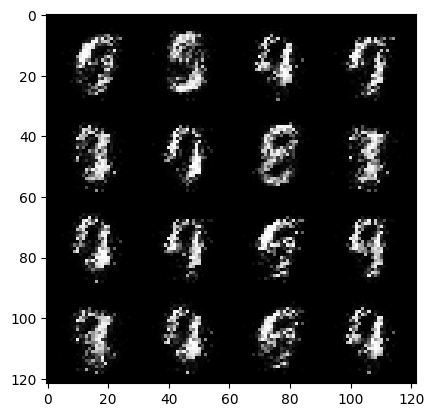

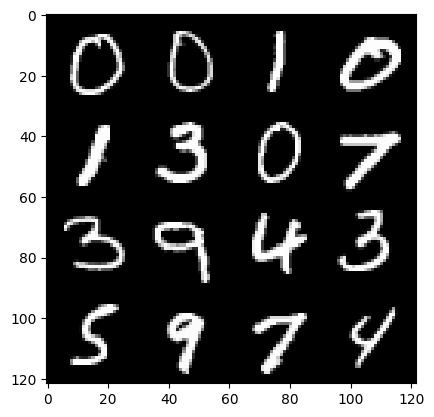

21: step 10500 / Gen loss: 6.448446618715917 / Disc loss: 0.012728123554649442


  0%|          | 0/469 [00:00<?, ?it/s]

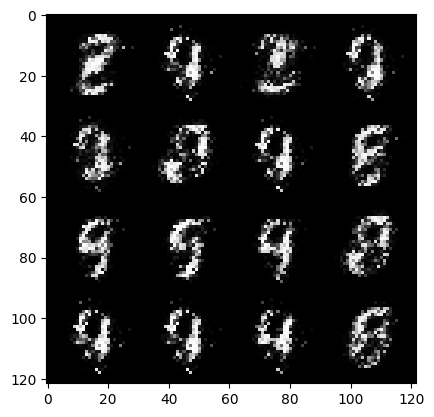

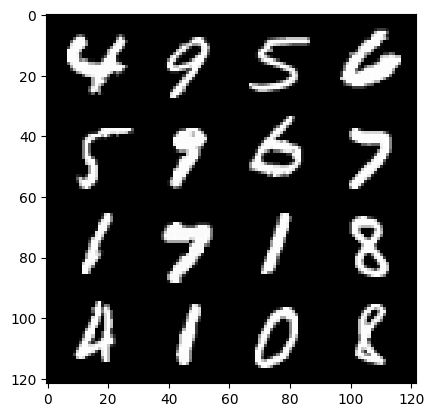

22: step 10800 / Gen loss: 6.506796536445614 / Disc loss: 0.012595945512875913


  0%|          | 0/469 [00:00<?, ?it/s]

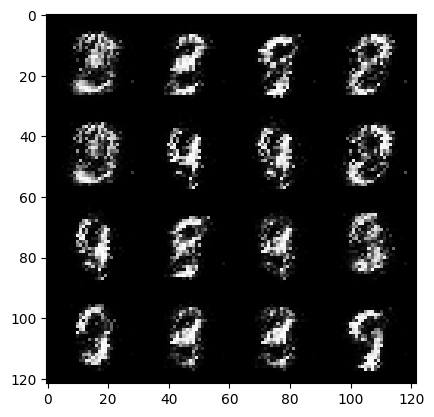

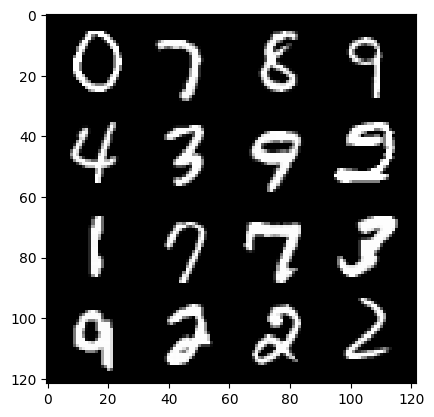

23: step 11100 / Gen loss: 6.88166678746541 / Disc loss: 0.011265866951240846


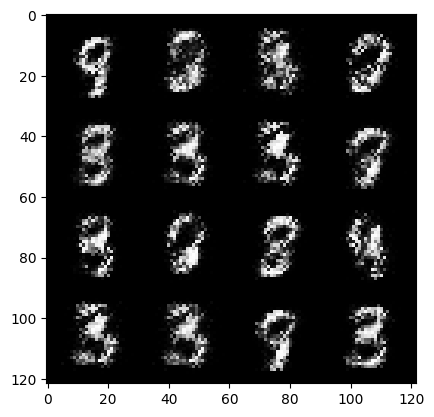

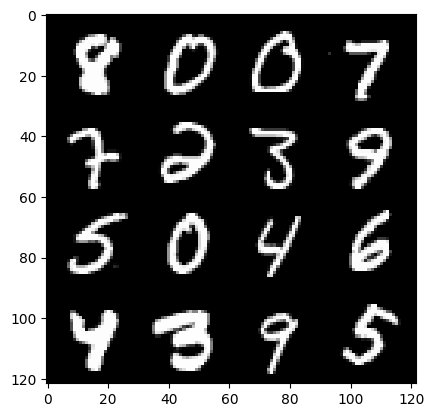

23: step 11400 / Gen loss: 6.3553263982137045 / Disc loss: 0.01537734242621809


  0%|          | 0/469 [00:00<?, ?it/s]

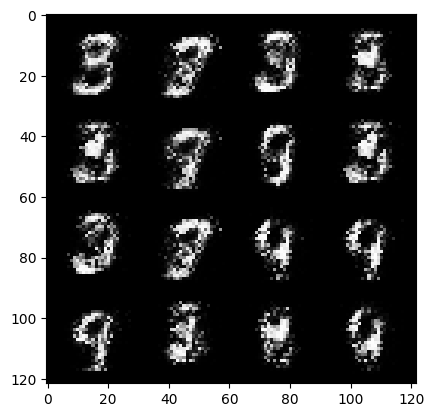

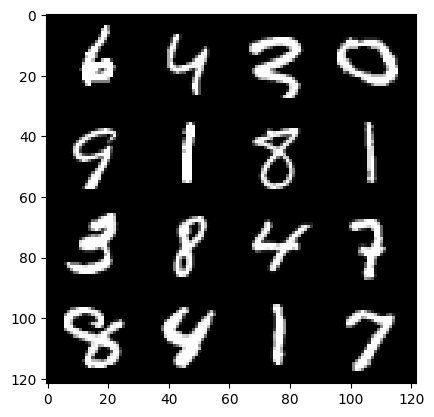

24: step 11700 / Gen loss: 6.535047116279606 / Disc loss: 0.016797052328474813


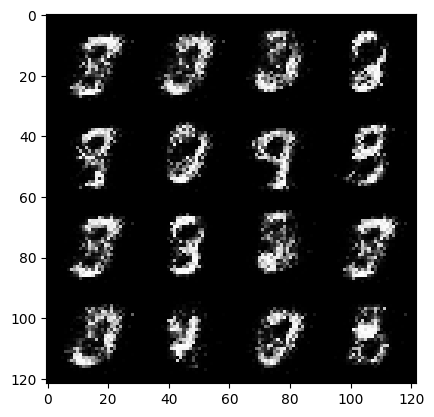

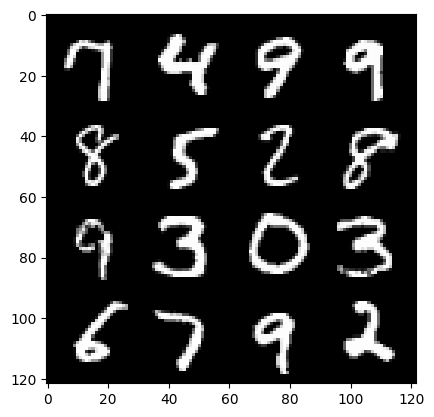

24: step 12000 / Gen loss: 6.470505291620891 / Disc loss: 0.017069602208212006


  0%|          | 0/469 [00:00<?, ?it/s]

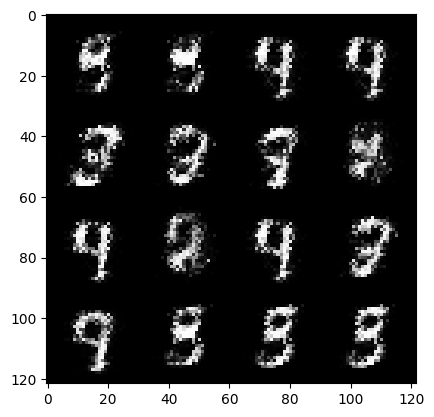

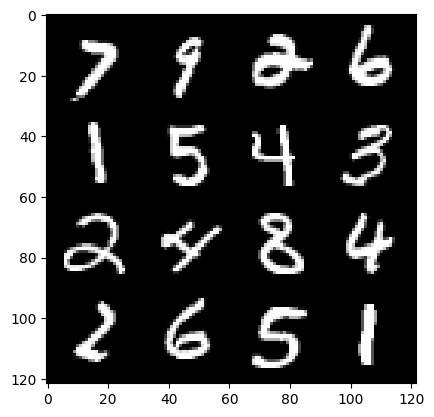

25: step 12300 / Gen loss: 6.279677287737531 / Disc loss: 0.01614228680497035


  0%|          | 0/469 [00:00<?, ?it/s]

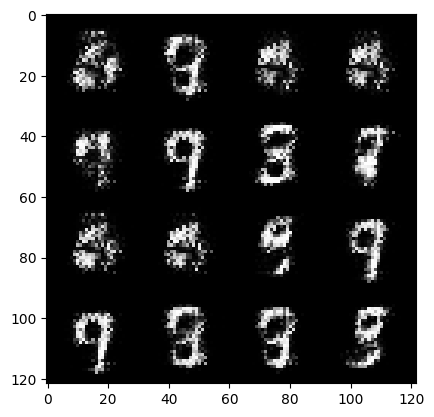

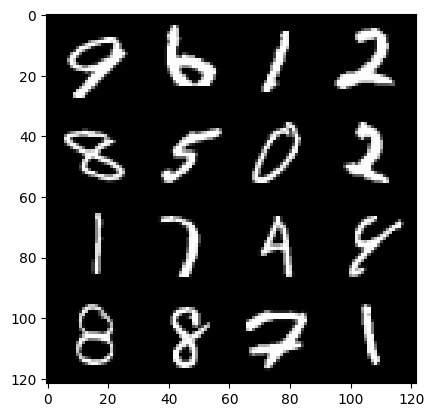

26: step 12600 / Gen loss: 6.8884191878636605 / Disc loss: 0.013880888635758306


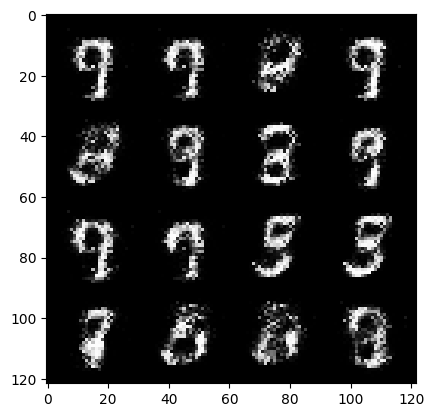

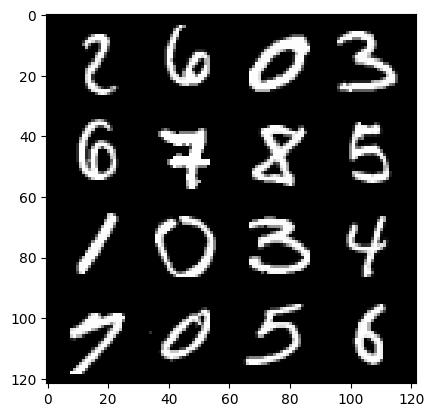

26: step 12900 / Gen loss: 6.478263130187988 / Disc loss: 0.01588218706349532


  0%|          | 0/469 [00:00<?, ?it/s]

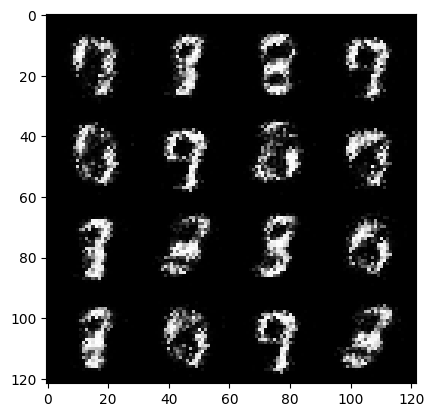

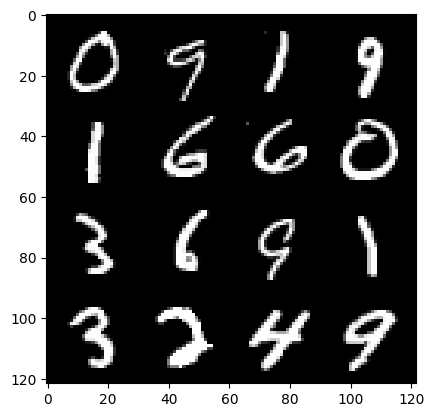

27: step 13200 / Gen loss: 6.18211398442586 / Disc loss: 0.017166908347668743


  0%|          | 0/469 [00:00<?, ?it/s]

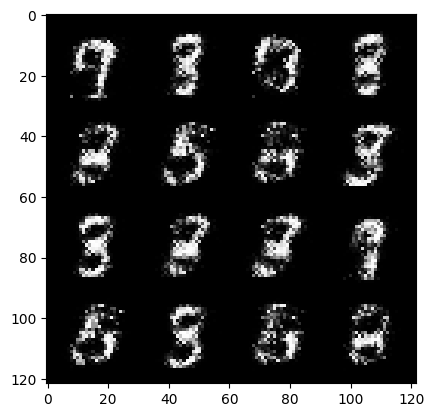

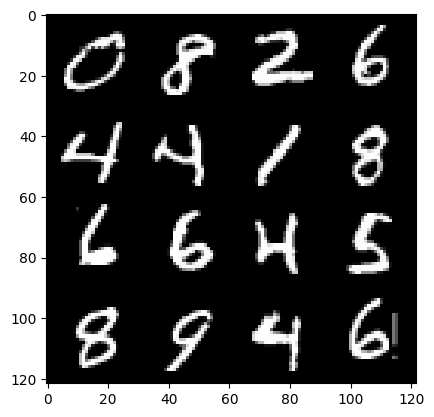

28: step 13500 / Gen loss: 6.272057153383889 / Disc loss: 0.01538568473343429


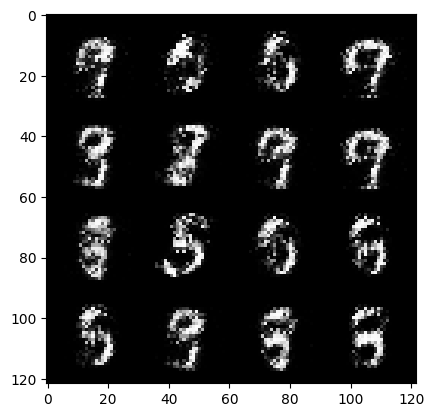

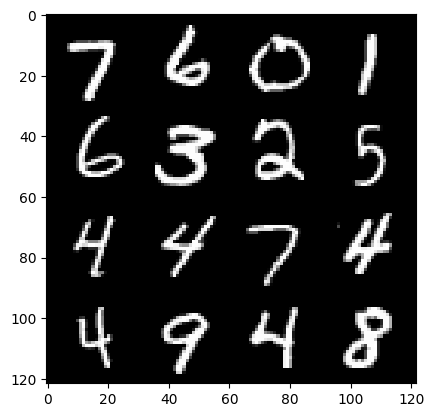

28: step 13800 / Gen loss: 6.666499643325806 / Disc loss: 0.01810571265018856


  0%|          | 0/469 [00:00<?, ?it/s]

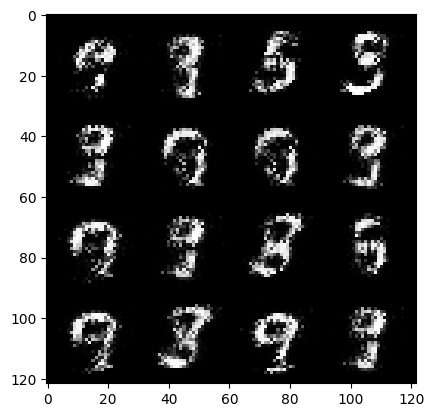

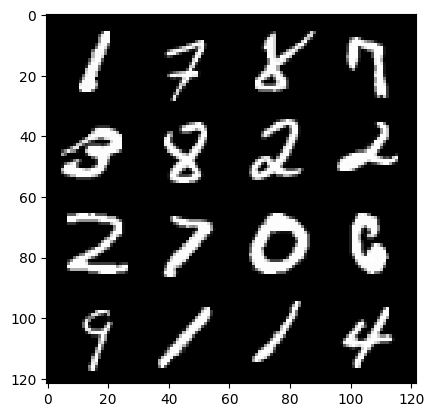

29: step 14100 / Gen loss: 6.58022836367289 / Disc loss: 0.021650290967275703


  0%|          | 0/469 [00:00<?, ?it/s]

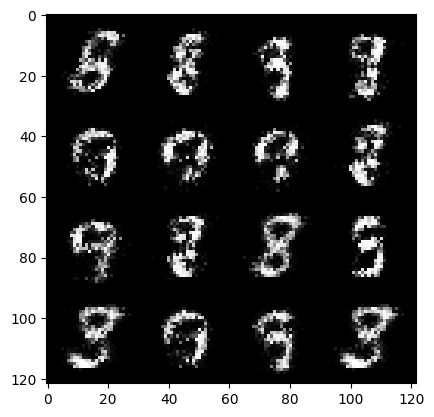

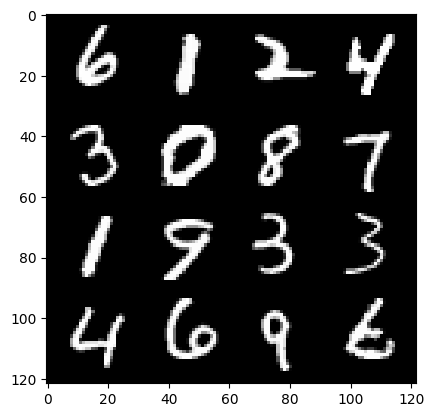

30: step 14400 / Gen loss: 6.340220173199972 / Disc loss: 0.022988292546942846


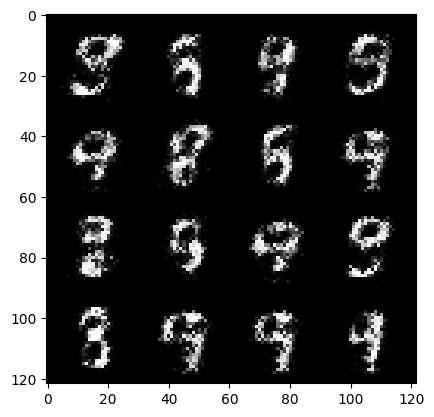

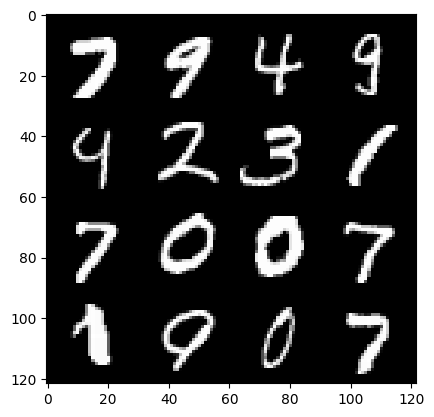

30: step 14700 / Gen loss: 6.38633046309153 / Disc loss: 0.023706834479235113


  0%|          | 0/469 [00:00<?, ?it/s]

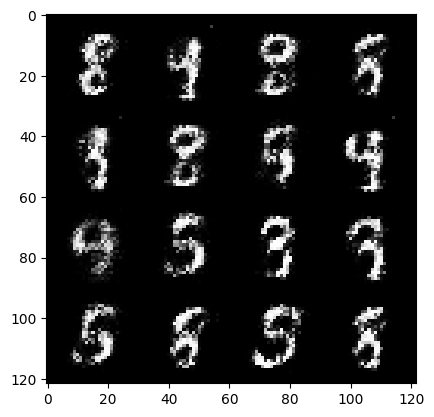

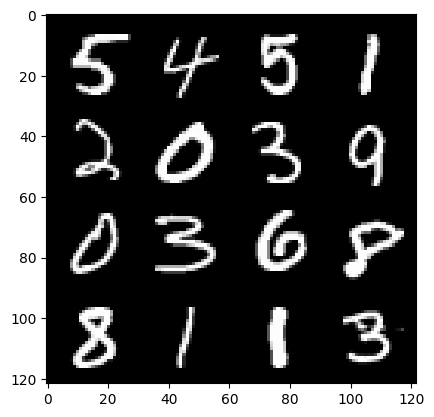

31: step 15000 / Gen loss: 6.056548080444338 / Disc loss: 0.0252252432036524


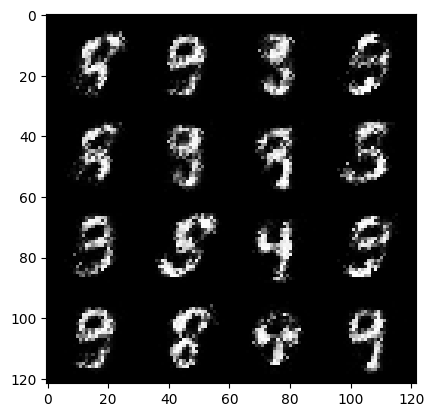

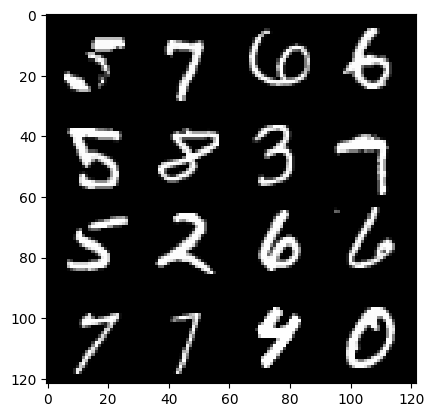

31: step 15300 / Gen loss: 6.143363615671801 / Disc loss: 0.029303120463155218


  0%|          | 0/469 [00:00<?, ?it/s]

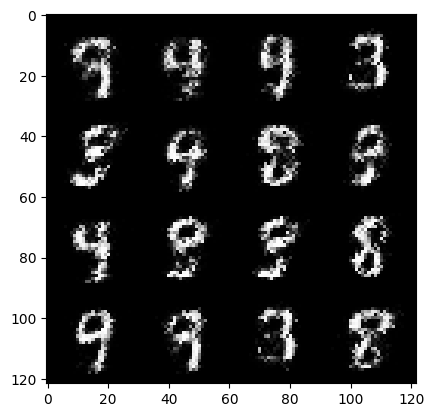

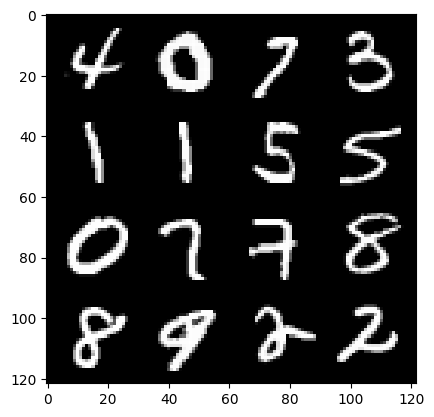

32: step 15600 / Gen loss: 6.198688824971514 / Disc loss: 0.02968816326620678


  0%|          | 0/469 [00:00<?, ?it/s]

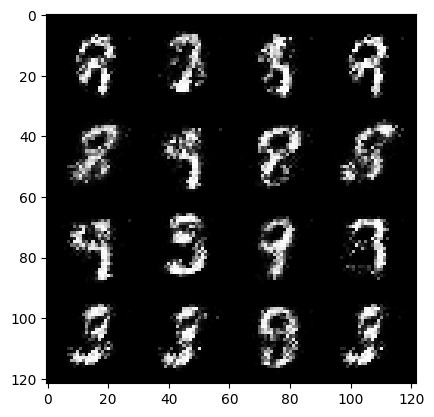

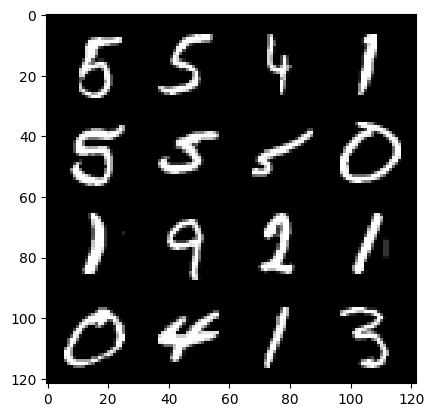

33: step 15900 / Gen loss: 6.2555158249537115 / Disc loss: 0.03293837152111032


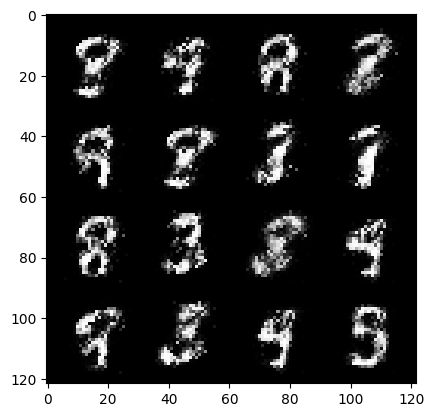

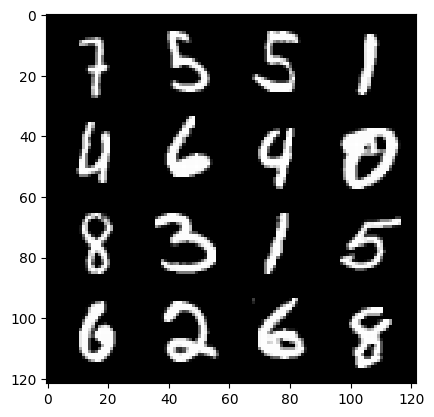

33: step 16200 / Gen loss: 5.835924903551738 / Disc loss: 0.032740356829017415


  0%|          | 0/469 [00:00<?, ?it/s]

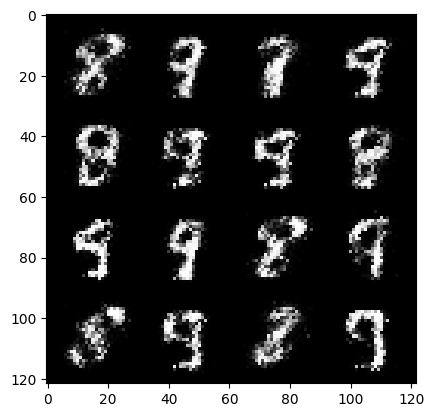

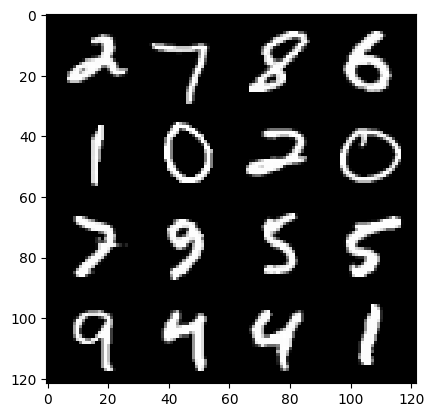

34: step 16500 / Gen loss: 5.8894732284545865 / Disc loss: 0.02956675889280937


  0%|          | 0/469 [00:00<?, ?it/s]

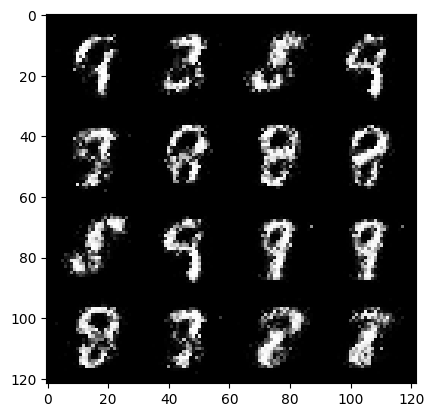

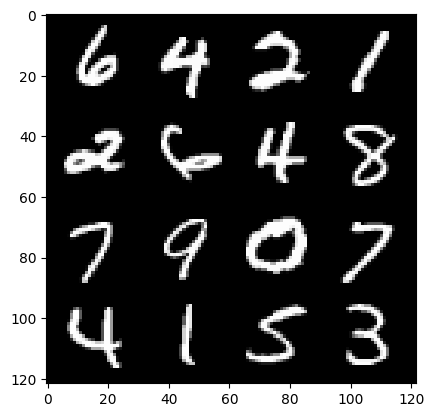

35: step 16800 / Gen loss: 6.049963445663449 / Disc loss: 0.03678389893223843


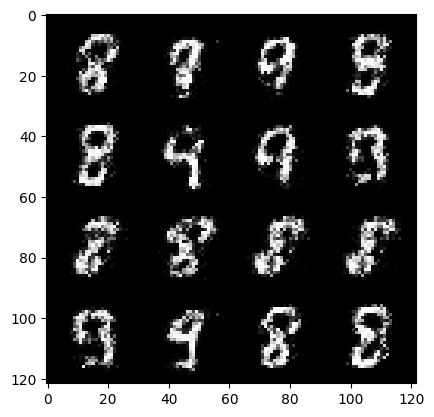

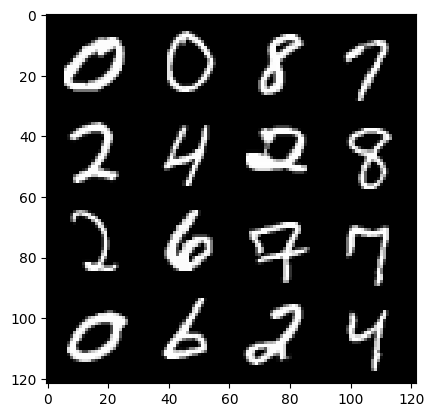

35: step 17100 / Gen loss: 5.79486241340637 / Disc loss: 0.03353848816361278


  0%|          | 0/469 [00:00<?, ?it/s]

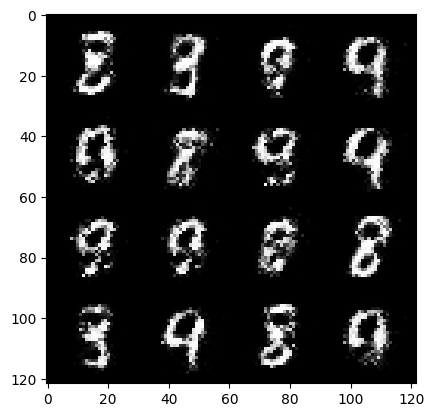

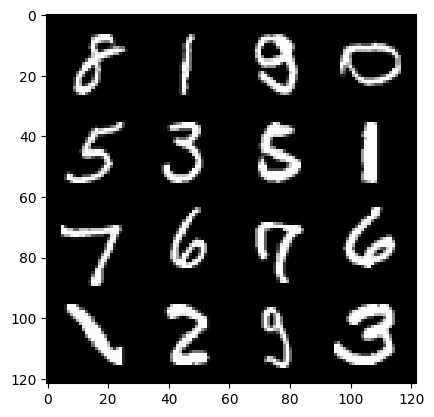

36: step 17400 / Gen loss: 5.686775280634561 / Disc loss: 0.037279170646021764


  0%|          | 0/469 [00:00<?, ?it/s]

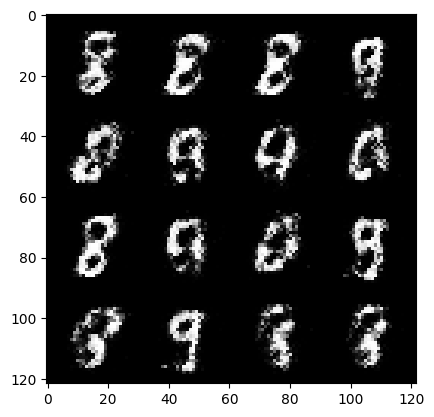

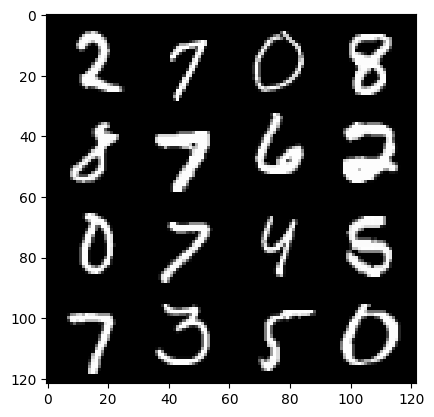

37: step 17700 / Gen loss: 5.418124543031057 / Disc loss: 0.04955127578849595


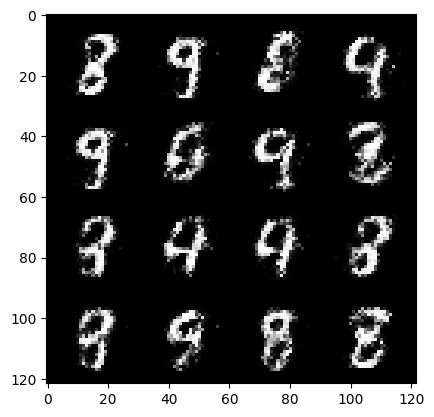

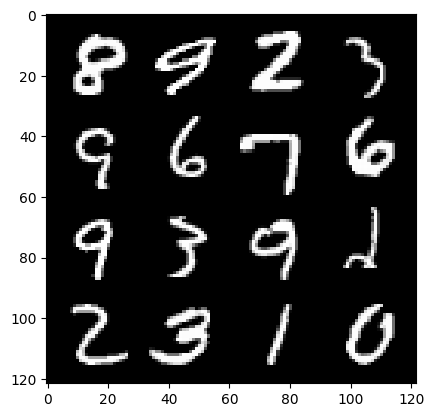

37: step 18000 / Gen loss: 5.301020226478573 / Disc loss: 0.03980451242843023


  0%|          | 0/469 [00:00<?, ?it/s]

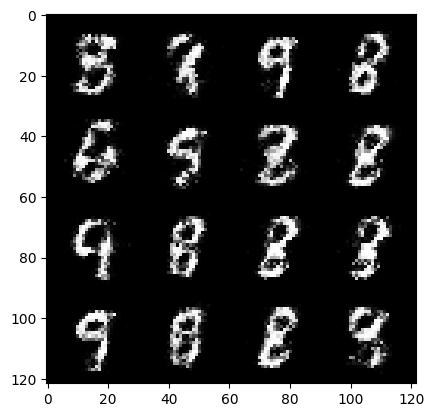

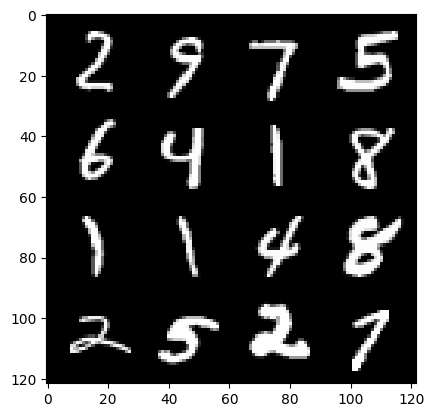

38: step 18300 / Gen loss: 5.329764599800112 / Disc loss: 0.041357987380276136


  0%|          | 0/469 [00:00<?, ?it/s]

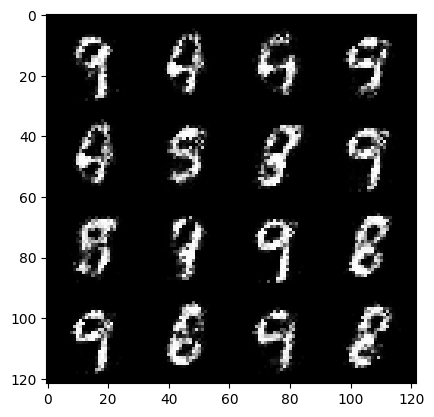

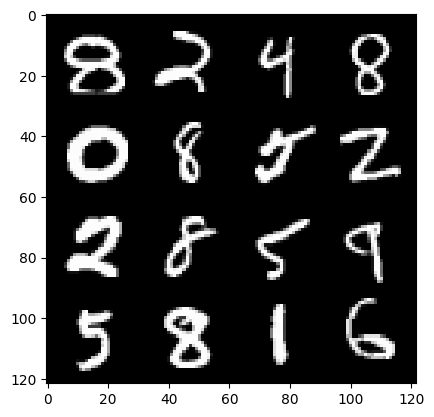

39: step 18600 / Gen loss: 5.3714830239613836 / Disc loss: 0.05060507396236063


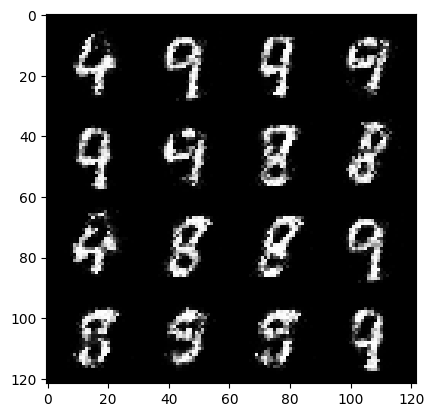

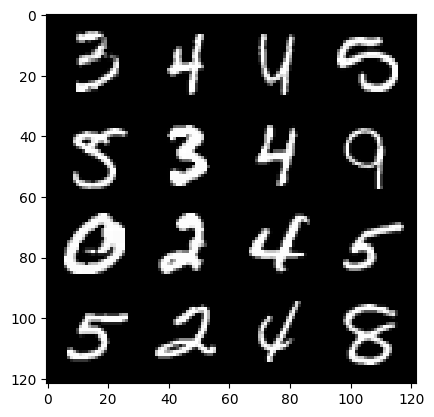

39: step 18900 / Gen loss: 5.486672849655151 / Disc loss: 0.04840551844798029


  0%|          | 0/469 [00:00<?, ?it/s]

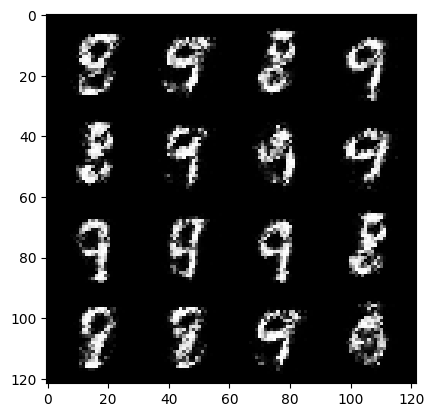

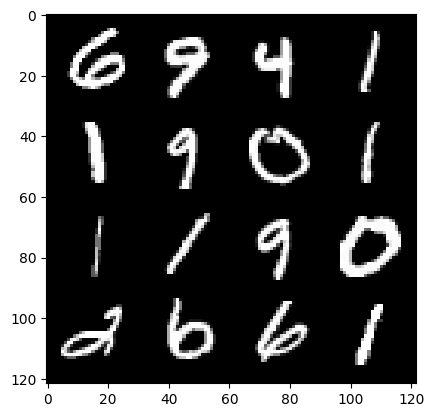

40: step 19200 / Gen loss: 5.497171419461574 / Disc loss: 0.05505650118303795


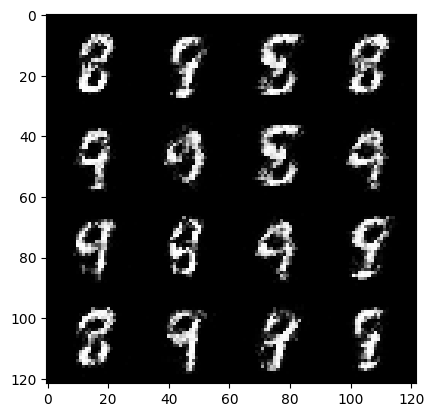

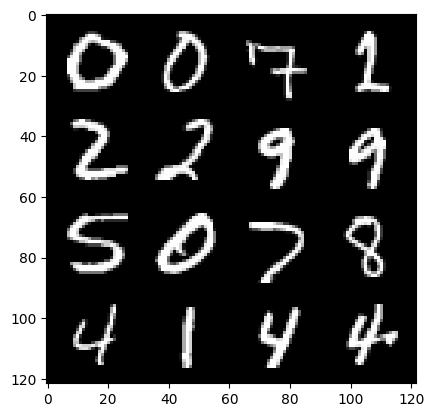

40: step 19500 / Gen loss: 5.434522121747336 / Disc loss: 0.056080837696790675


  0%|          | 0/469 [00:00<?, ?it/s]

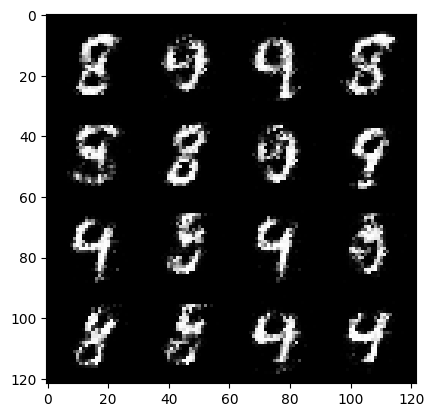

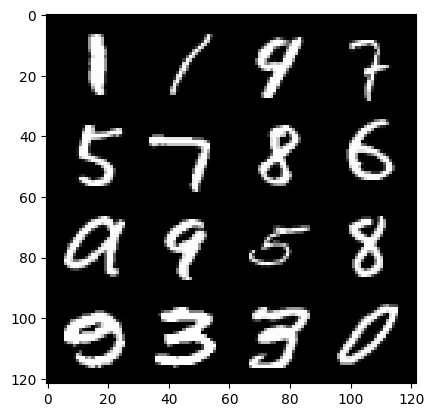

41: step 19800 / Gen loss: 4.886852941513062 / Disc loss: 0.05928146119539939


  0%|          | 0/469 [00:00<?, ?it/s]

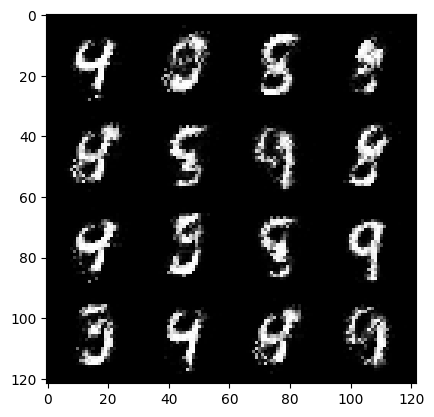

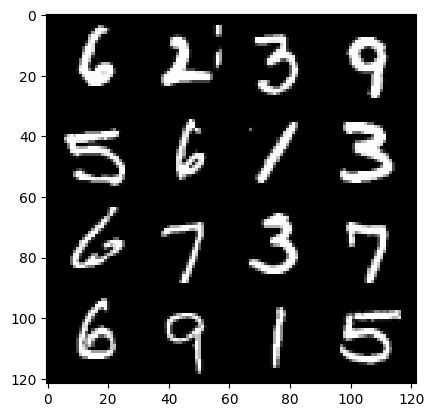

42: step 20100 / Gen loss: 5.268076214790344 / Disc loss: 0.05318064869691926


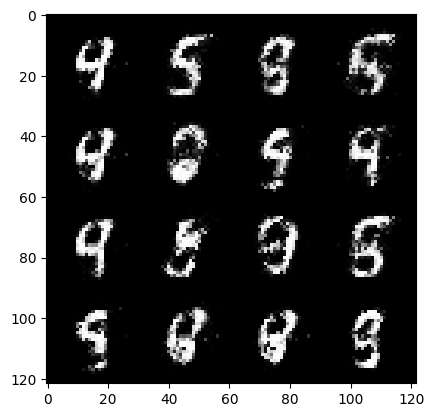

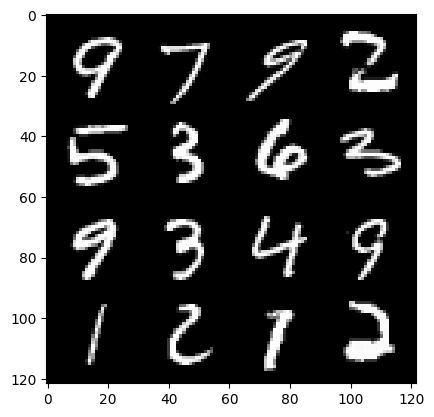

42: step 20400 / Gen loss: 5.3195400190353315 / Disc loss: 0.058799193222075684


  0%|          | 0/469 [00:00<?, ?it/s]

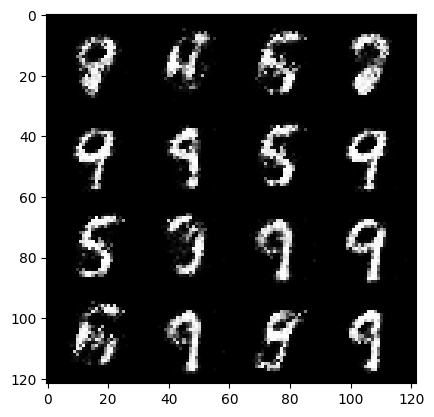

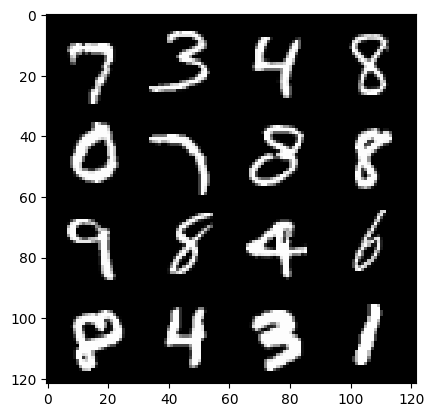

43: step 20700 / Gen loss: 5.064377627372743 / Disc loss: 0.060306365502377314


  0%|          | 0/469 [00:00<?, ?it/s]

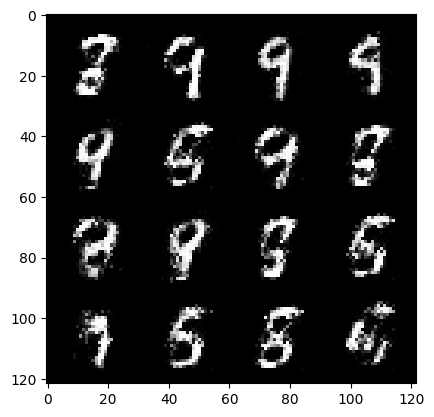

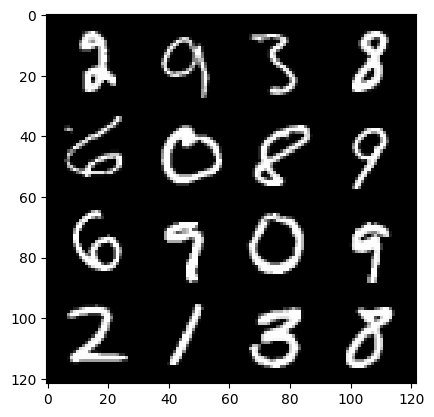

44: step 21000 / Gen loss: 4.986266059080762 / Disc loss: 0.06772350034986935


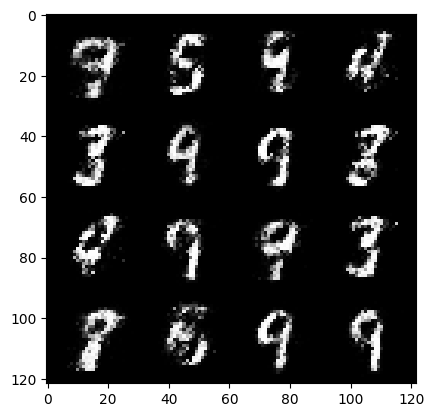

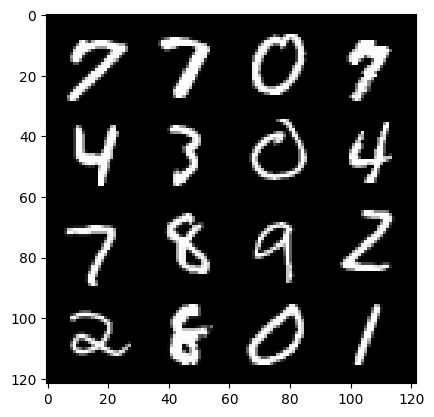

44: step 21300 / Gen loss: 4.88488232453664 / Disc loss: 0.0700049840720991


  0%|          | 0/469 [00:00<?, ?it/s]

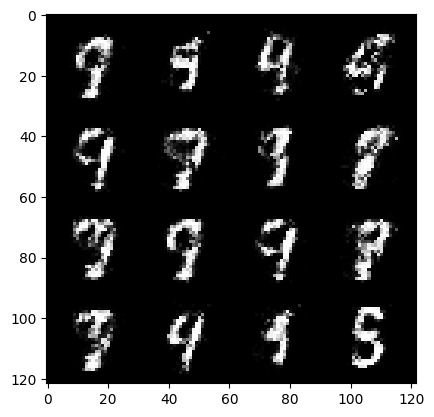

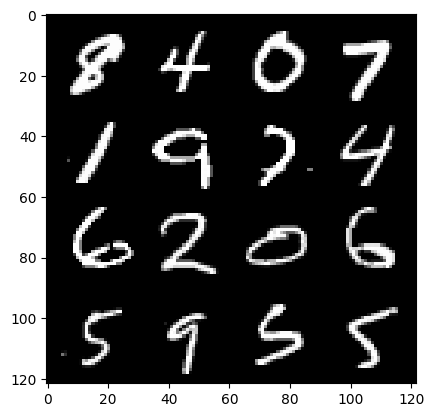

45: step 21600 / Gen loss: 4.747153943379724 / Disc loss: 0.07382528957600398


  0%|          | 0/469 [00:00<?, ?it/s]

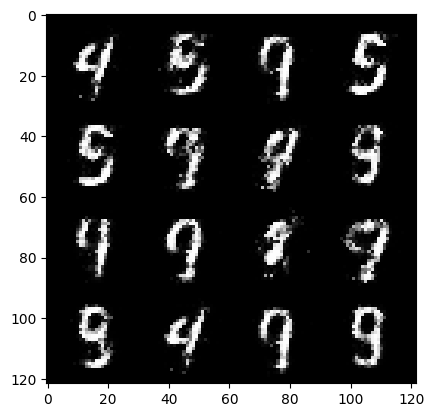

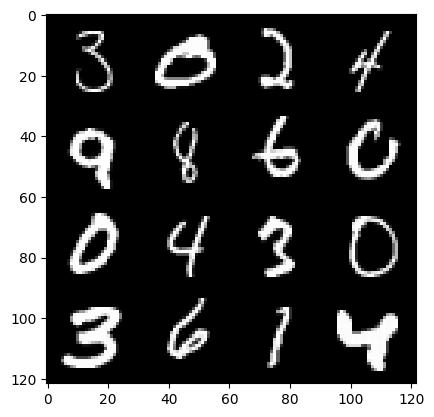

46: step 21900 / Gen loss: 4.676660684744517 / Disc loss: 0.08180308760454254


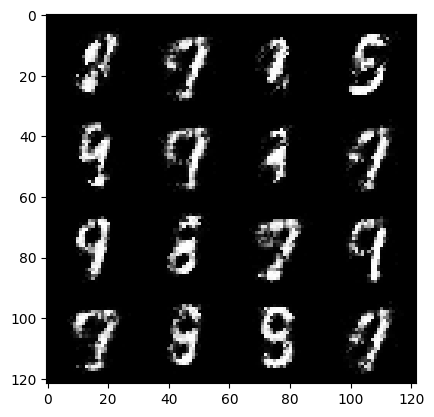

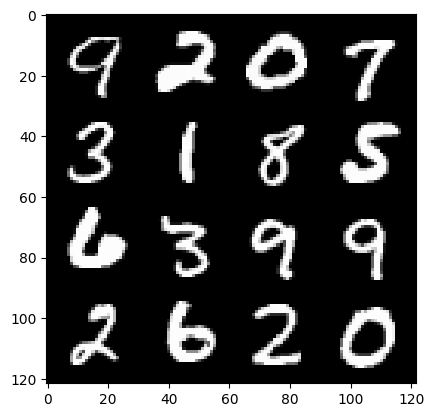

46: step 22200 / Gen loss: 4.642671811580659 / Disc loss: 0.0778527132359644


  0%|          | 0/469 [00:00<?, ?it/s]

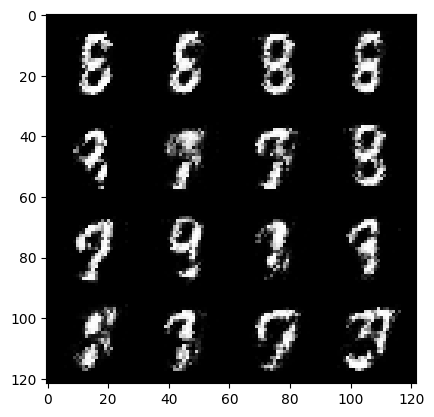

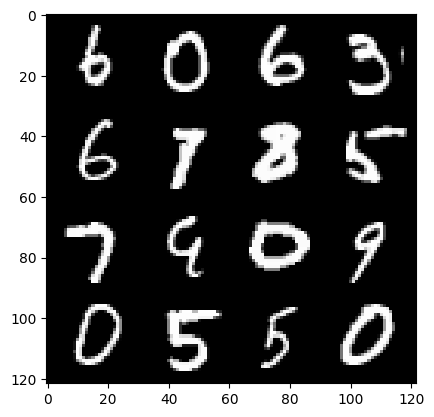

47: step 22500 / Gen loss: 4.608603302637736 / Disc loss: 0.07238553528984387


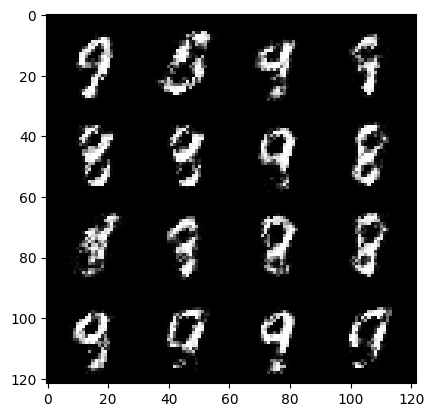

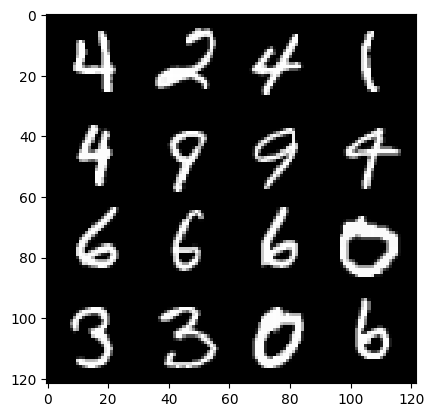

47: step 22800 / Gen loss: 4.695161685943609 / Disc loss: 0.07961810100823648


  0%|          | 0/469 [00:00<?, ?it/s]

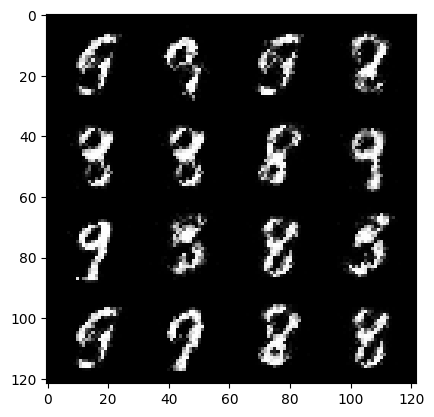

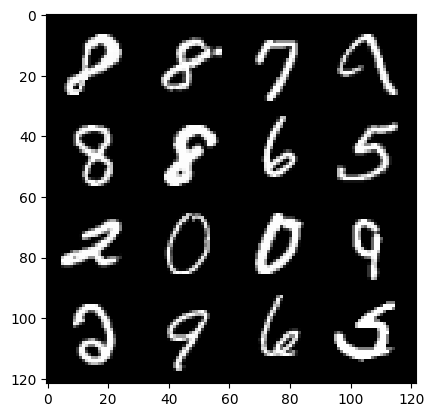

48: step 23100 / Gen loss: 4.81698534568151 / Disc loss: 0.07958151012659068


  0%|          | 0/469 [00:00<?, ?it/s]

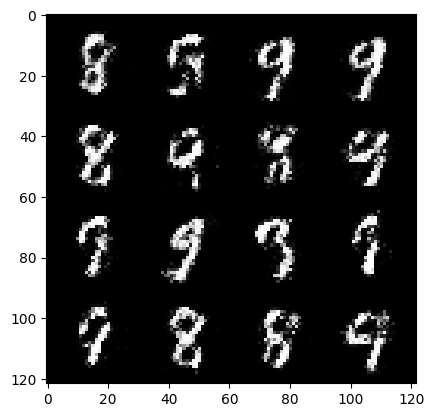

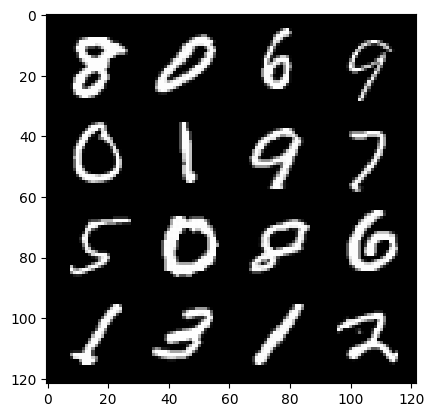

49: step 23400 / Gen loss: 4.840086286067965 / Disc loss: 0.06977040329327185


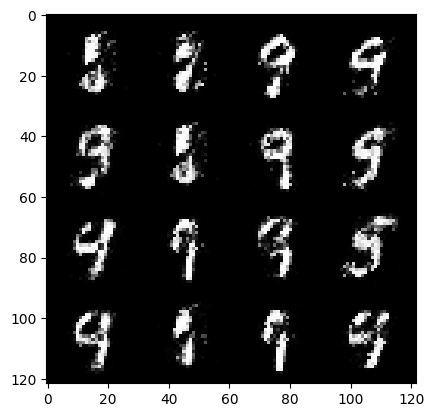

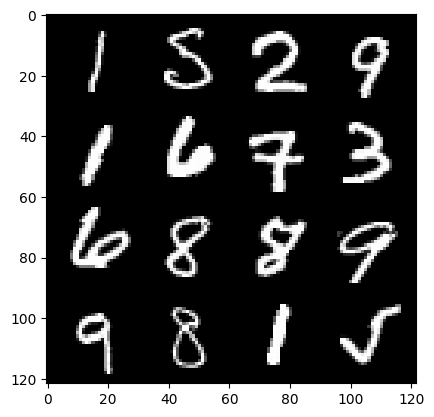

49: step 23700 / Gen loss: 4.720991493066153 / Disc loss: 0.0778853101904193


  0%|          | 0/469 [00:00<?, ?it/s]

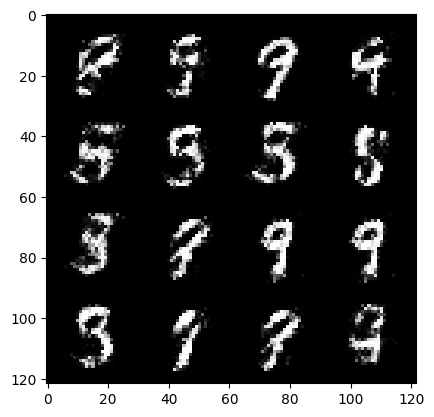

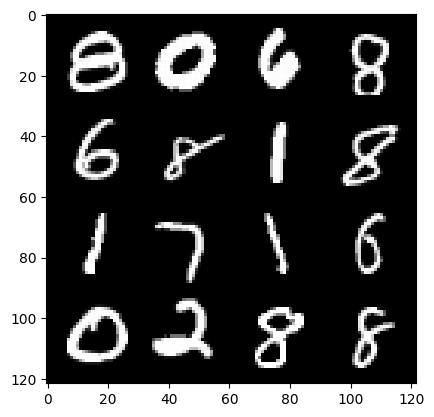

50: step 24000 / Gen loss: 4.873768531481423 / Disc loss: 0.08521259820709629


  0%|          | 0/469 [00:00<?, ?it/s]

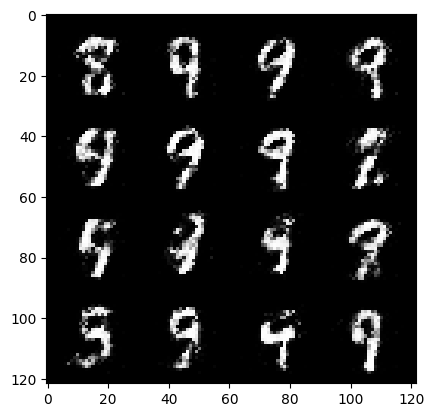

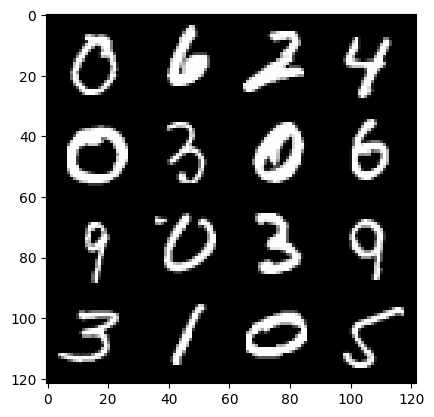

51: step 24300 / Gen loss: 4.693187450567883 / Disc loss: 0.09232938925425208


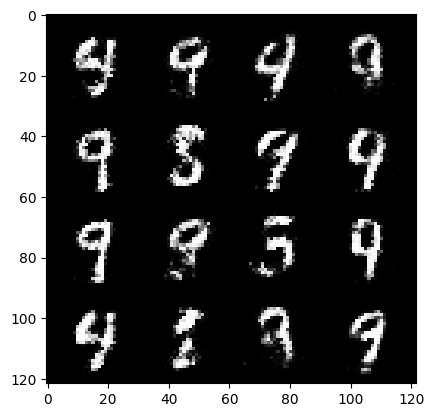

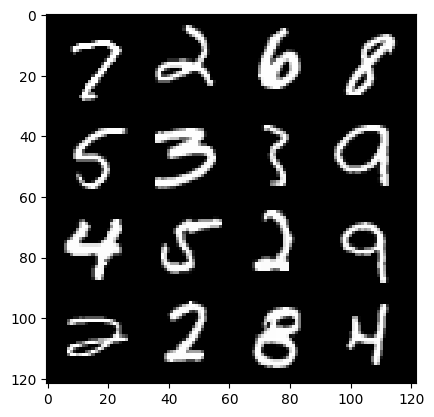

51: step 24600 / Gen loss: 4.5115921847025575 / Disc loss: 0.09166664401069284


  0%|          | 0/469 [00:00<?, ?it/s]

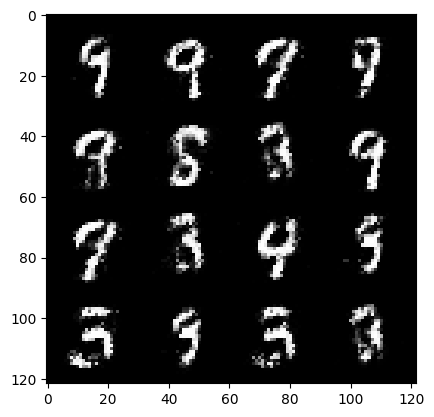

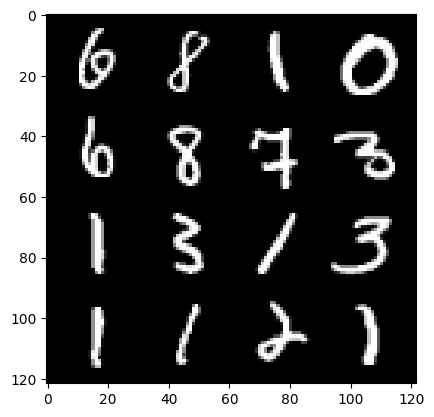

52: step 24900 / Gen loss: 4.435528478622439 / Disc loss: 0.09807608451073375


  0%|          | 0/469 [00:00<?, ?it/s]

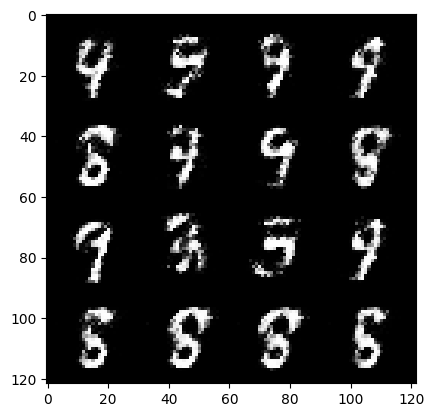

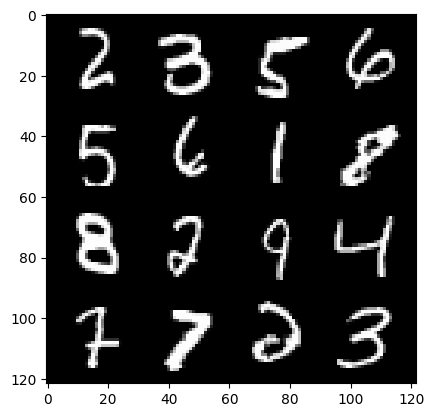

53: step 25200 / Gen loss: 4.222733600934343 / Disc loss: 0.0994943995028734


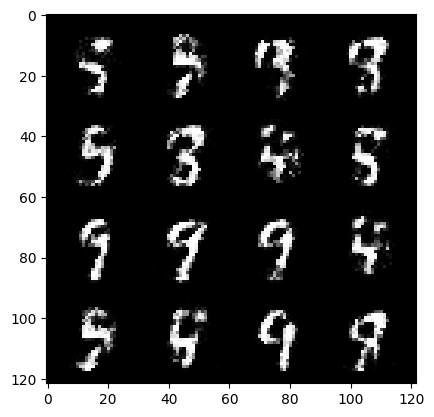

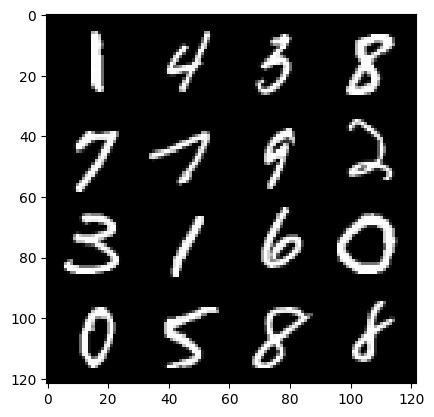

53: step 25500 / Gen loss: 4.241588738759359 / Disc loss: 0.09248971230039998


  0%|          | 0/469 [00:00<?, ?it/s]

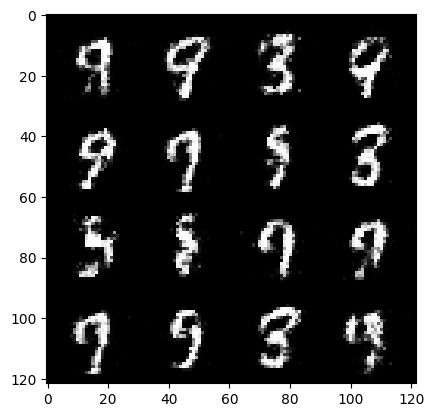

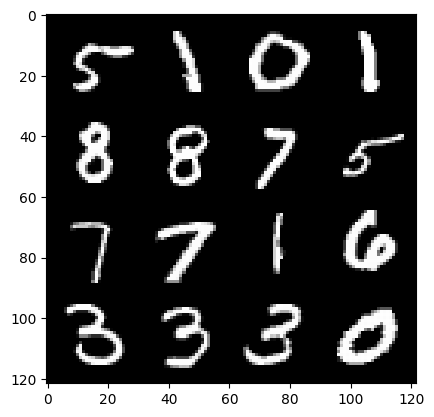

54: step 25800 / Gen loss: 4.277957471211749 / Disc loss: 0.09157542869448661


  0%|          | 0/469 [00:00<?, ?it/s]

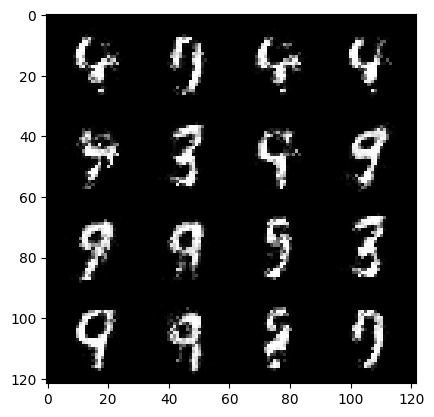

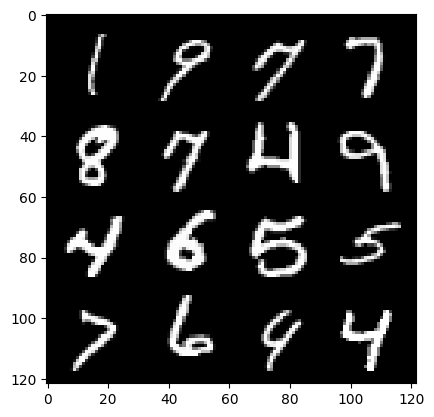

55: step 26100 / Gen loss: 4.2555410019556685 / Disc loss: 0.09139143609752258


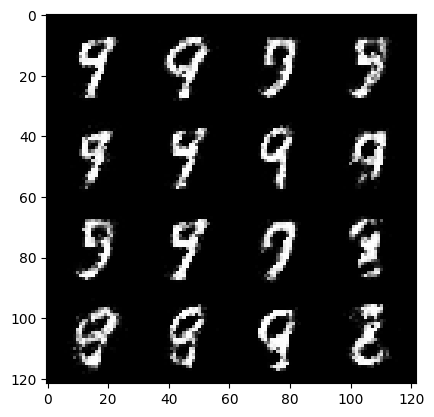

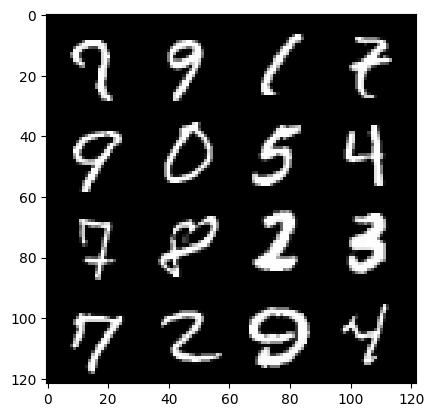

55: step 26400 / Gen loss: 4.161795293490091 / Disc loss: 0.10815111223608241


  0%|          | 0/469 [00:00<?, ?it/s]

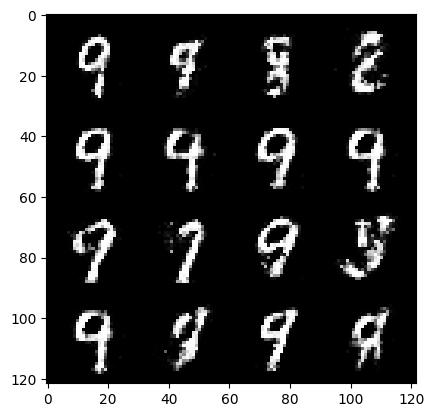

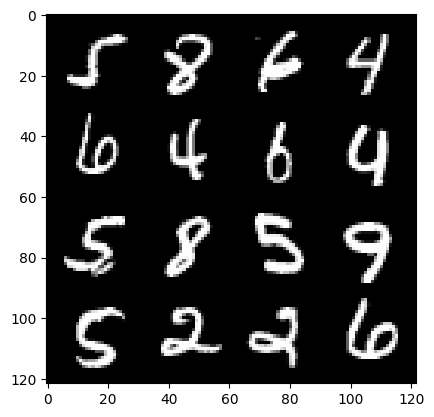

56: step 26700 / Gen loss: 4.085470798015592 / Disc loss: 0.1085511028021574


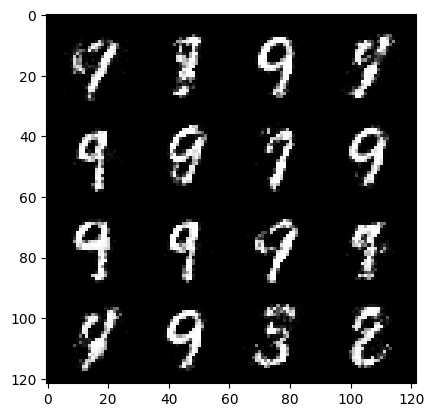

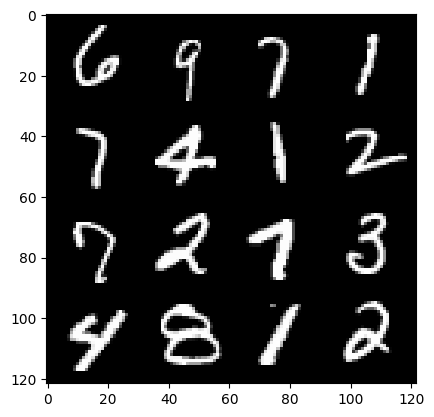

56: step 27000 / Gen loss: 4.186288998126981 / Disc loss: 0.10438384732852382


  0%|          | 0/469 [00:00<?, ?it/s]

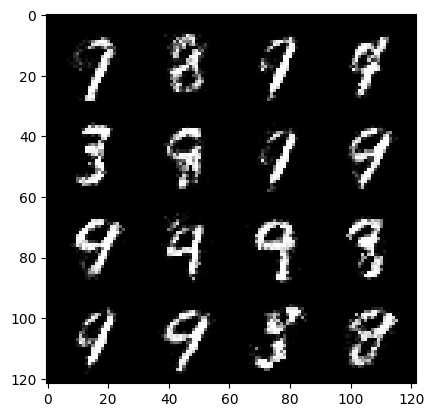

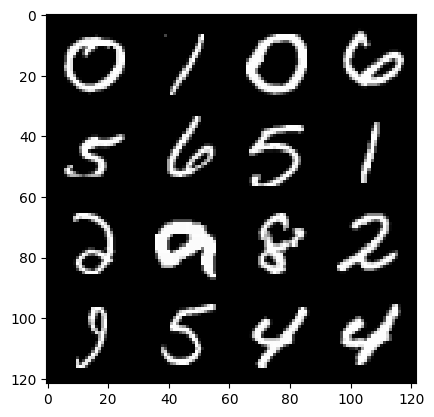

57: step 27300 / Gen loss: 4.097413955529532 / Disc loss: 0.10825352080166337


  0%|          | 0/469 [00:00<?, ?it/s]

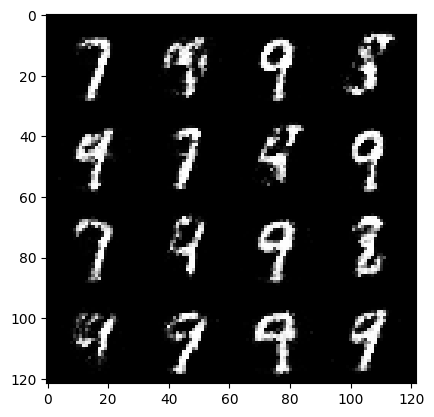

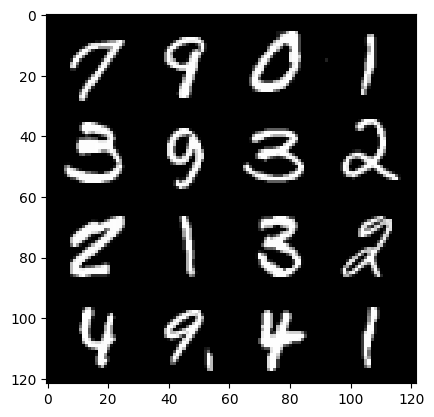

58: step 27600 / Gen loss: 4.037317032019296 / Disc loss: 0.11582394998520613


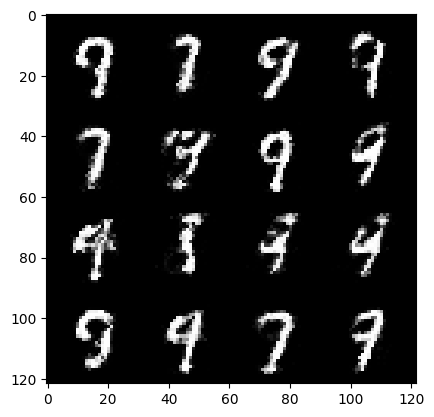

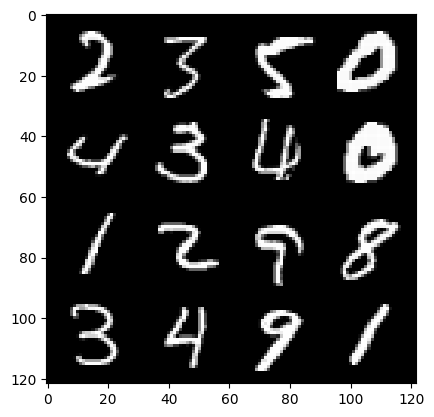

58: step 27900 / Gen loss: 3.870859295527138 / Disc loss: 0.11841441368063291


  0%|          | 0/469 [00:00<?, ?it/s]

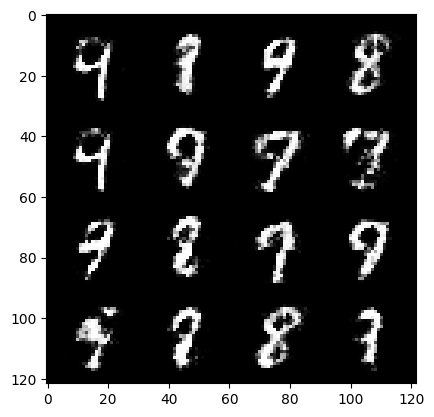

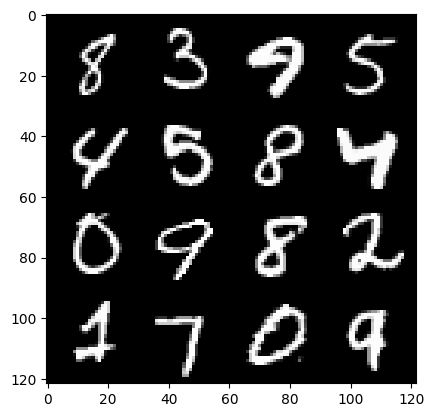

59: step 28200 / Gen loss: 3.871031828721365 / Disc loss: 0.13205872709552455


  0%|          | 0/469 [00:00<?, ?it/s]

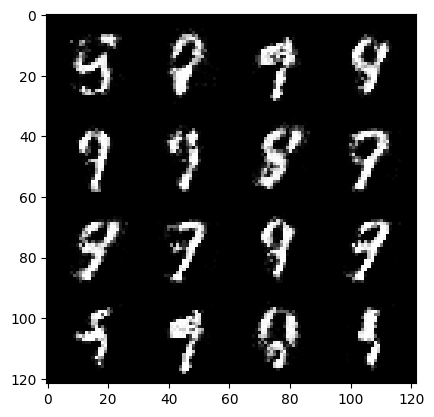

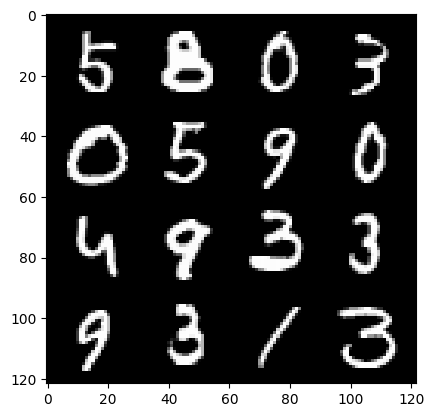

60: step 28500 / Gen loss: 3.836821114222209 / Disc loss: 0.1451306227346262


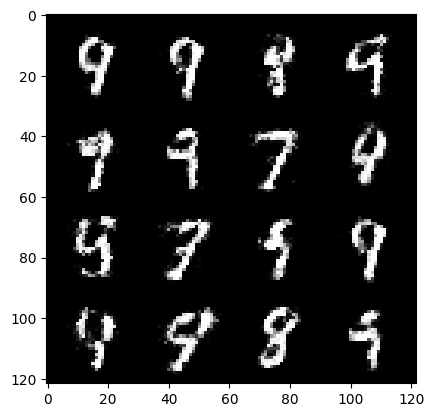

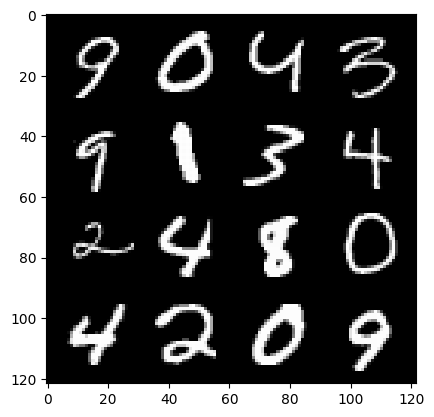

60: step 28800 / Gen loss: 3.703274242877958 / Disc loss: 0.1354929640640815


  0%|          | 0/469 [00:00<?, ?it/s]

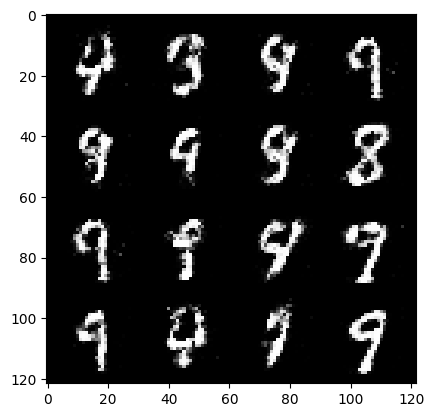

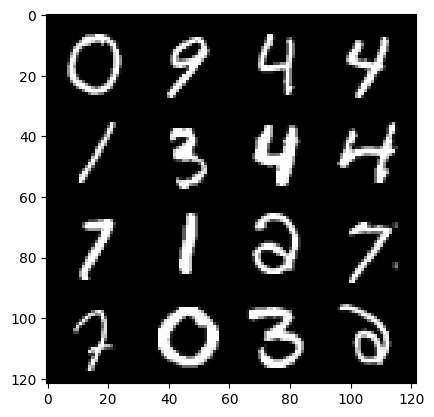

61: step 29100 / Gen loss: 3.6721985141436253 / Disc loss: 0.1167049973333875


  0%|          | 0/469 [00:00<?, ?it/s]

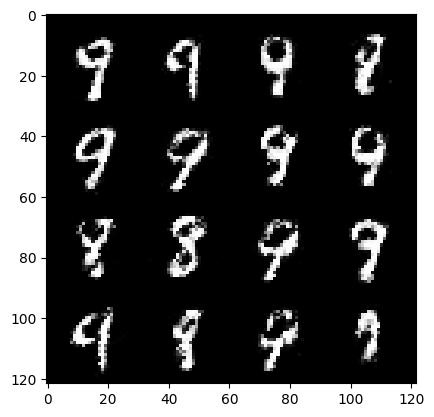

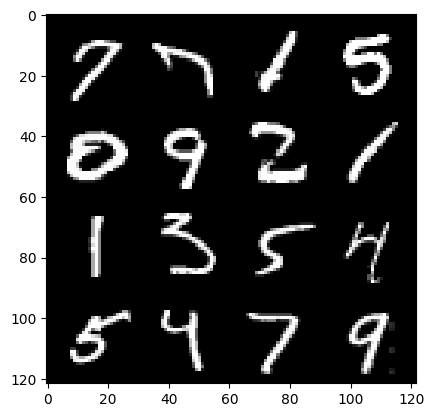

62: step 29400 / Gen loss: 3.6009384298324583 / Disc loss: 0.13261846657842402


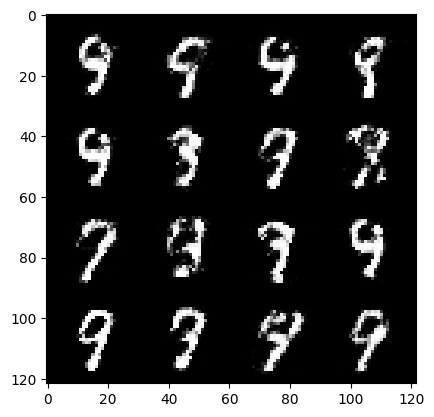

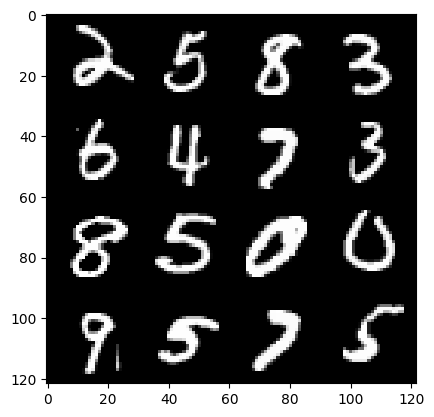

62: step 29700 / Gen loss: 3.7098265655835463 / Disc loss: 0.11710622010131688


  0%|          | 0/469 [00:00<?, ?it/s]

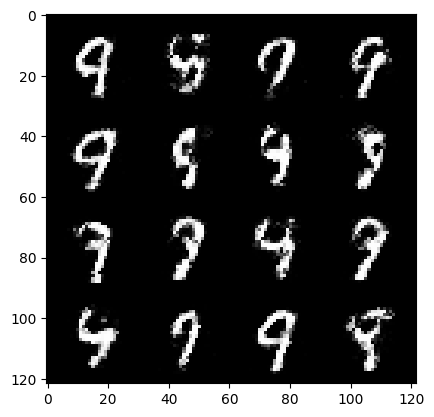

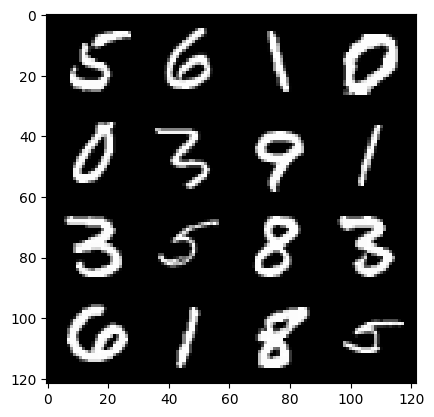

63: step 30000 / Gen loss: 3.8335880049069715 / Disc loss: 0.12065633676946168


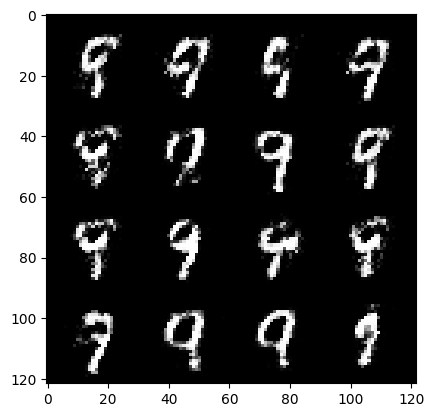

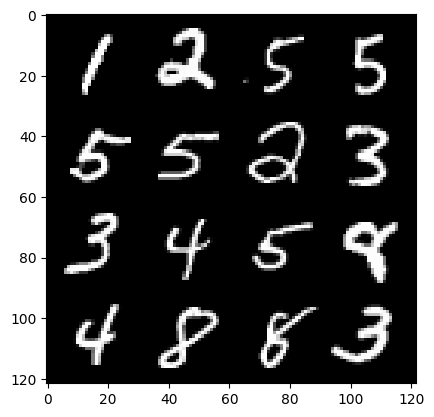

63: step 30300 / Gen loss: 3.6713266563415496 / Disc loss: 0.131684148684144


  0%|          | 0/469 [00:00<?, ?it/s]

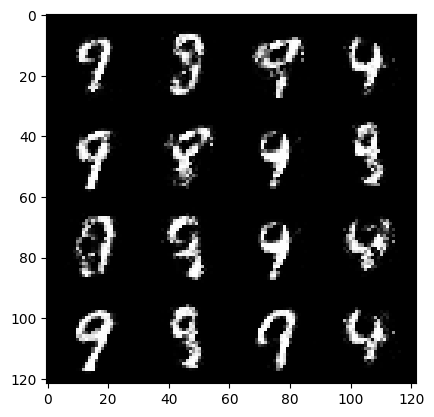

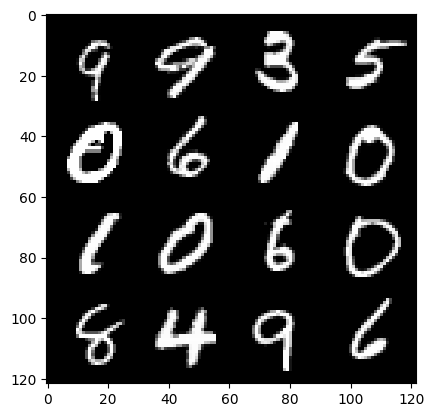

64: step 30600 / Gen loss: 3.729723230202995 / Disc loss: 0.12077120250711838


  0%|          | 0/469 [00:00<?, ?it/s]

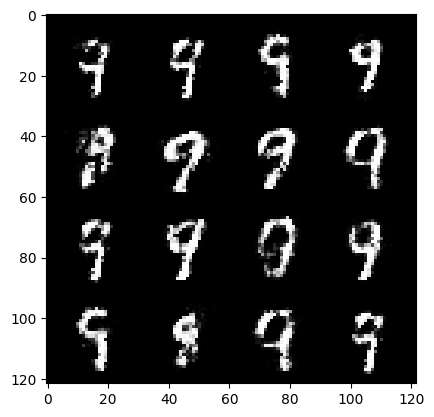

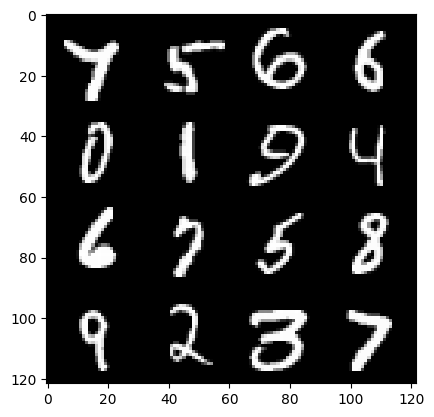

65: step 30900 / Gen loss: 3.597817786534629 / Disc loss: 0.1339204995458326


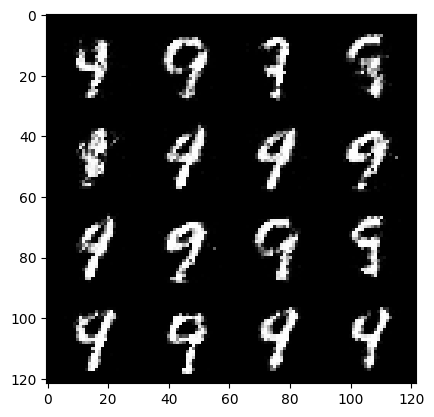

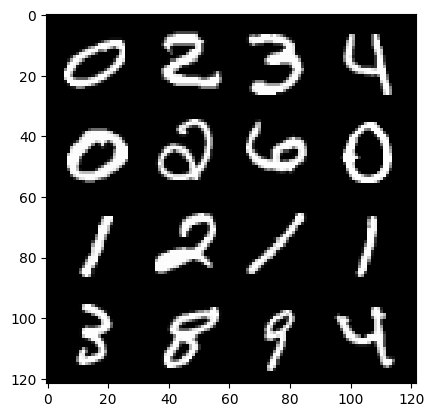

65: step 31200 / Gen loss: 3.5948476950327546 / Disc loss: 0.13711870674043905


  0%|          | 0/469 [00:00<?, ?it/s]

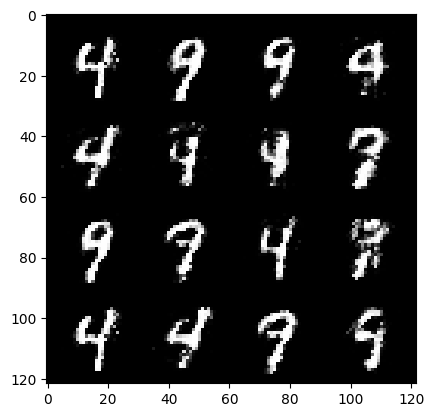

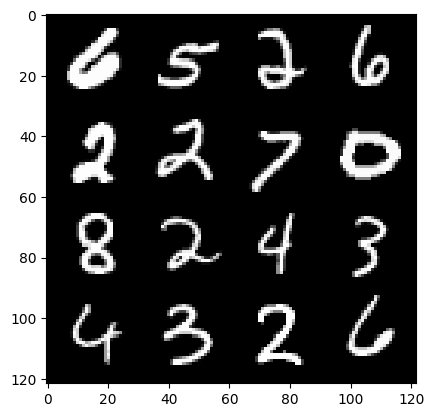

66: step 31500 / Gen loss: 3.7066921591758724 / Disc loss: 0.11527678175518906


  0%|          | 0/469 [00:00<?, ?it/s]

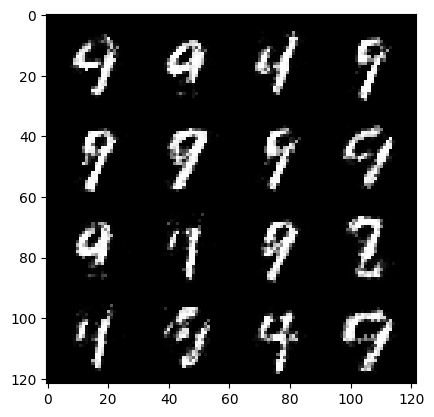

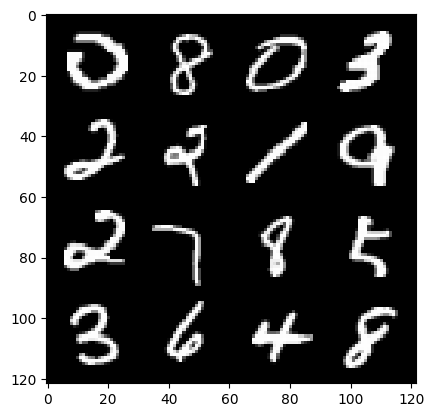

67: step 31800 / Gen loss: 3.7403481698036187 / Disc loss: 0.13072600928445657


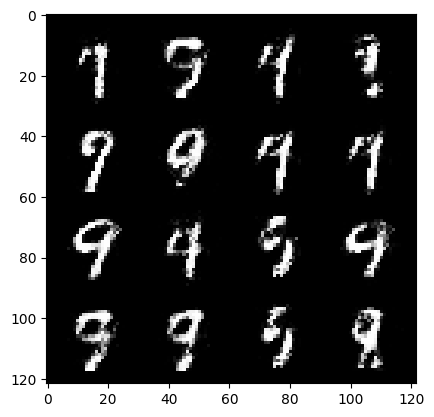

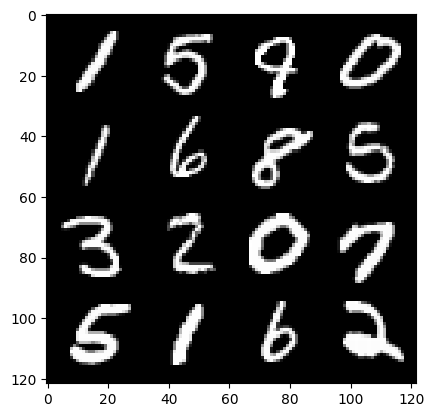

67: step 32100 / Gen loss: 3.726552941004435 / Disc loss: 0.12385670936355987


  0%|          | 0/469 [00:00<?, ?it/s]

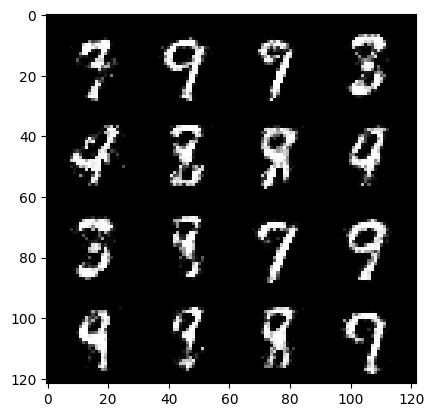

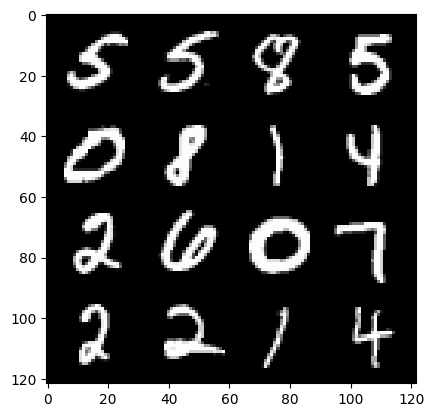

68: step 32400 / Gen loss: 3.7798407522837305 / Disc loss: 0.10759244979669648


  0%|          | 0/469 [00:00<?, ?it/s]

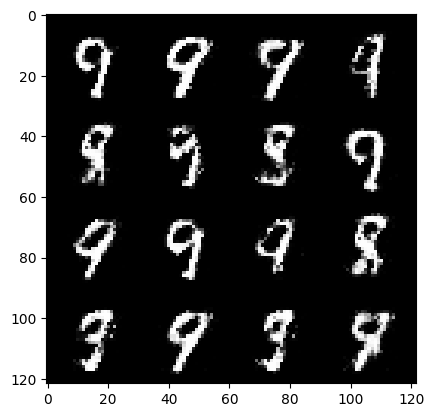

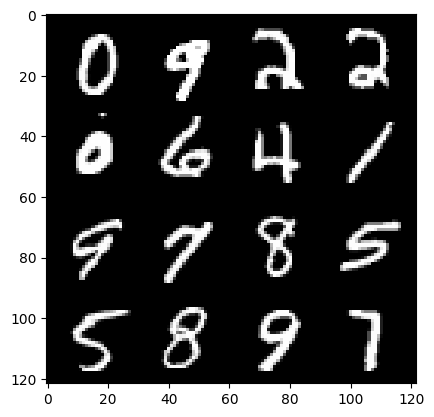

69: step 32700 / Gen loss: 3.717407655715942 / Disc loss: 0.1309441929931443


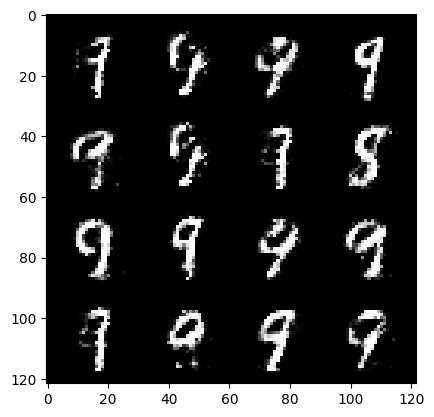

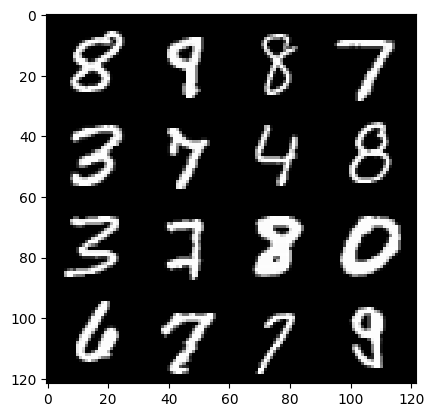

69: step 33000 / Gen loss: 3.687981793880462 / Disc loss: 0.13140006583183997


In [ ]:
# 600000 / 128 = 468.75 = 469 steps in each epoch
# each step is going to process 128 images = size of the batch(except the last step)

for epoch in range(epochs):
  for real,_ in tqdm(dataloader):
    # discriminator
    disc_opt.zero_grad()

    cur_bs=len(real)  # real : 128 * 1 * 28 * 28
    real= real.view(cur_bs,-1)  # 128 * 784(reshaping)
    real = real.to(device) # storing image in the gpu

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True) # we backpropogatte
    disc_opt.step()  # applying step function (update or tweak the parameters)

    # generator
    gen_opt.zero_grad()
    gen_loss=calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()


    # visualization and stats
    mean_disc_loss+=disc_loss.item()/info_step    # item() will transform a tensor to a standalone number
    mean_gen_loss+=gen_loss.item()/info_step


    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise=gen_noise(cur_bs,z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")
      mean_gen_loss,mean_disc_loss=0,0
    cur_step+=1